In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [26]:
def color_feature(image,size=(32,32),Bineachchannel=16):
    img= cv2.resize(image, size)
    a=np.histogram(img[:,:,2], bins=Bineachchannel, range=(0, 1))
    b=np.histogram(img[:,:,1], bins=Bineachchannel, range=(0, 1))
    c=np.histogram(img[:,:,0], bins=Bineachchannel, range=(0, 1))
    
    
    img=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    d=np.histogram(img[:,:,2], bins=Bineachchannel, range=(0, 1))
    e=np.histogram(img[:,:,1], bins=Bineachchannel, range=(0, 1))
    f=np.histogram(img[:,:,0], bins=Bineachchannel, range=(0, 1))
    
    img=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    g=np.histogram(img[:,:,2], bins=Bineachchannel, range=(0, 1))
    h=np.histogram(img[:,:,1], bins=Bineachchannel, range=(0, 1))
    l=np.histogram(img[:,:,0], bins=Bineachchannel, range=(0, 1))
    
    
    result=np.concatenate((a[0],b[0],c[0],d[0],e[0],f[0],g[0],h[0],l[0]),axis=0)
    return result

    

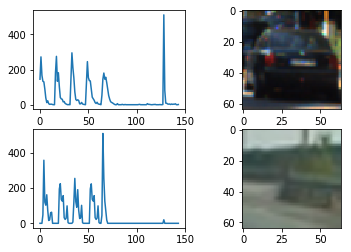

In [27]:
image=mpimg.imread("./vehicles/KITTI_extracted/5969.png")
img=color_feature(image)
plt.subplot(2,2,2)
plt.imshow(image)

plt.subplot(2,2,1)
plt.plot(img)


image=mpimg.imread("./non-vehicles/GTI/image10.png")
img=color_feature(image)
plt.subplot(2,2,4)
plt.imshow(image)

plt.subplot(2,2,3)
plt.plot(img)

In [28]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9
def HOG(image):
    #img= cv2.resize(image, (32,32))
    image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    
    
    return hog_image

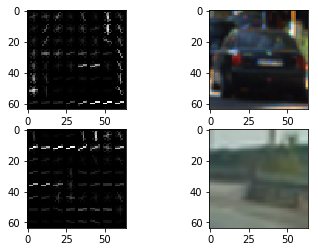

In [29]:
image=mpimg.imread("./vehicles/KITTI_extracted/5969.png")
img=HOG(image)
plt.subplot(2,2,2)
plt.imshow(image)

plt.subplot(2,2,1)
plt.imshow(img,cmap="gray")




image=mpimg.imread("./non-vehicles/GTI/image10.png")
img=HOG(image)
plt.subplot(2,2,4)
plt.imshow(image)

plt.subplot(2,2,3)
plt.imshow(img,cmap="gray")

In [30]:
pix_per_cell = 16
cell_per_block = 2
orient = 11

def HOG(image):
    #img= cv2.resize(image, (32,32))
    image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
    
    
    return features.ravel()

In [31]:
def feature_extract(image):
    a=color_feature(image)
    b=HOG(image)
    c=np.concatenate((a,b),axis=0)
    return c

In [32]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()

In [33]:
import glob
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
Y=[]
X=[]

for image in images:
    if 'non' in image:
        img=mpimg.imread(image)
        img=feature_extract(img)
        X.append(img)
        Y.append(0)
    else:
        img=mpimg.imread(image)
        img=feature_extract(img)
        X.append(img)
        Y.append(1)

print(np.shape(X))
print(np.shape(Y))




(17761, 540)
(17761,)


In [34]:
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
import time
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_scaler.fit(X_train)
X_train=X_scaler.transform(X_train)
X_test=X_scaler.transform(X_test)

svc = SVC(C=5,probability=True) # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) 

61.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


In [35]:
print (svc.predict_proba(X_test[2:5]))
print (y_test[2:5])

[[  9.99999654e-01   3.45998988e-07]
 [  9.51838979e-01   4.81610213e-02]
 [  9.99824118e-01   1.75881745e-04]]
[0, 0, 0]


In [36]:
from scipy.ndimage.measurements import label

#image=mpimg.imread("./test_images/test2.jpg")

class CarTracker():
    def __init__(self):
        self.Box_buffer={}
        self.n_frame=0
        self.Round=0
        
    def draw_labeled_bboxes(self,img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    def apply_threshold(self,heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def Find_car(self,image):
        if self.n_frame<5:
            self.n_frame=self.n_frame+1
            self.Box_buffer[str(self.n_frame)]=[]
        original_image=np.copy(image)
        image=image[360:600,300:,:]
        original_img=np.zeros_like(original_image[:,:,0])
        
        img=np.zeros_like(image[:,:,0])
        Overlap=3
        Box_size=[64,80,96]
        X,Y=np.shape(img)[0:2]
        count=0
        
        if self.n_frame<=5 and self.Round==0  :
            if self.n_frame==5:
                self.Round=1
                
            for i in Box_size:
                if i==80:
                    Overlap=4
                if i==96:
                    Overlap=6
                n_x=int((X-i/Overlap)/i*Overlap)
                n_y=int((Y-i/Overlap)/i*Overlap)
                #print (n_x,n_y)
                for j in range(n_x):
                    for k in range(n_y):
                        count=count+1
                        Clip_img=original_image[(360+int(j*i/Overlap)):(360+int(j*i/Overlap+i)),int(300+k*i/Overlap):int(300+k*i/Overlap+i),:]
                        raw_img= cv2.resize(Clip_img, (64,64))
                        img_feature=feature_extract(raw_img)
                        img_feature=np.reshape(img_feature,(1,len(img_feature)))
                        img_feature=X_scaler.transform(img_feature)
                        if svc.predict_proba(img_feature)[0][1]>0.5:
                            self.Box_buffer[str(self.n_frame)].append([int(360+int(j*i/Overlap)),int(360+int(j*i/Overlap+i)),int(300+k*i/Overlap),int(300+k*i/Overlap+i)])

        
        else:
            self.Box_buffer[str(self.Round)]=[]

            for i in Box_size:
                n_x=int((X-i/Overlap)/i*Overlap)
                n_y=int((Y-i/Overlap)/i*Overlap)
                #print (n_x,n_y)
                for j in range(n_x):
                    for k in range(n_y):
                        count=count+1
                        Clip_img=original_image[(360+int(j*i/Overlap)):(360+int(j*i/Overlap+i)),int(300+k*i/Overlap):int(300+k*i/Overlap+i),:]
                        raw_img= cv2.resize(Clip_img, (64,64))
                        img_feature=feature_extract(raw_img)
                        img_feature=np.reshape(img_feature,(1,len(img_feature)))
                        img_feature=X_scaler.transform(img_feature)
                        if svc.predict_proba(img_feature)[0][1]>0.6:
                            self.Box_buffer[str(self.Round)].append([int(360+int(j*i/Overlap)),int(360+int(j*i/Overlap+i)),int(300+k*i/Overlap),int(300+k*i/Overlap+i)])
        
            if self.Round<5:
                self.Round=self.Round+1
            else:
                self.Round=1
        
        
        count=0
        for j in self.Box_buffer.keys():
            print (j)
            for i in self.Box_buffer[j]:
                count=count+1
                original_img[i[0]:i[1],i[2]:i[3]]=original_img[i[0]:i[1],i[2]:i[3]]+1
        print (count)
        original_img=self.apply_threshold(original_img, threshold=18)
    

        labels = label(original_img)#,structure=s)
        draw_img = self.draw_labeled_bboxes(original_image, labels)

        return draw_img

34
1


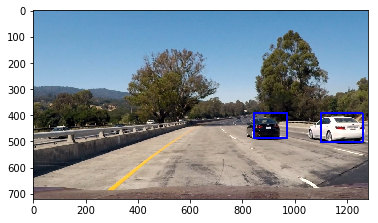

In [476]:
image=mpimg.imread("./test_images/test1.jpg")
track=CarTracker()
img=track.Find_car(image)
print (track.n_frame)
plt.imshow(img)

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [486]:
track=CarTracker()
white_output = './Result_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(track.Find_car) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

1
34
[MoviePy] >>>> Building video ./Result_video.mp4
[MoviePy] Writing video ./Result_video.mp4









  0%|          | 0/39 [00:00<?, ?it/s]






  3%|▎         | 1/39 [00:02<01:34,  2.49s/it]

1
2
68









  5%|▌         | 2/39 [00:05<01:32,  2.50s/it]

1
2
3
99









  8%|▊         | 3/39 [00:07<01:29,  2.49s/it]

1
2
3
4
126









 10%|█         | 4/39 [00:10<01:28,  2.53s/it]

1
2
3
4
5
151









 13%|█▎        | 5/39 [00:12<01:25,  2.51s/it]

1
2
3
4
5
147









 15%|█▌        | 6/39 [00:15<01:22,  2.49s/it]

1
2
3
4
5
137









 18%|█▊        | 7/39 [00:17<01:18,  2.45s/it]

1
2
3
4
5
136









 21%|██        | 8/39 [00:19<01:16,  2.45s/it]

1
2
3
4
5
132









 23%|██▎       | 9/39 [00:22<01:13,  2.44s/it]

1
2
3
4
5
136









 26%|██▌       | 10/39 [00:24<01:10,  2.42s/it]

1
2
3
4
5
127









 28%|██▊       | 11/39 [00:27<01:07,  2.42s/it]

1
2
3
4
5
146









 31%|███       | 12/39 [00:29<01:04,  2.40s/it]

1
2
3
4
5
150









 33%|███▎      | 13/39 [00:31<01:02,  2.39s/it]

1
2
3
4
5
164









 36%|███▌      | 14/39 [00:34<00:59,  2.39s/it]

1
2
3
4
5
168









 38%|███▊      | 15/39 [00:36<00:57,  2.39s/it]

1
2
3
4
5
184









 41%|████      | 16/39 [00:38<00:55,  2.40s/it]

1
2
3
4
5
167









 44%|████▎     | 17/39 [00:41<00:52,  2.39s/it]

1
2
3
4
5
164









 46%|████▌     | 18/39 [00:43<00:50,  2.40s/it]

1
2
3
4
5
152









 49%|████▊     | 19/39 [00:46<00:47,  2.40s/it]

1
2
3
4
5
144









 51%|█████▏    | 20/39 [00:48<00:45,  2.41s/it]

1
2
3
4
5
132









 54%|█████▍    | 21/39 [00:50<00:43,  2.41s/it]

1
2
3
4
5
132









 56%|█████▋    | 22/39 [00:53<00:40,  2.41s/it]

1
2
3
4
5
125









 59%|█████▉    | 23/39 [00:55<00:38,  2.40s/it]

1
2
3
4
5
128









 62%|██████▏   | 24/39 [00:58<00:35,  2.40s/it]

1
2
3
4
5
134









 64%|██████▍   | 25/39 [01:00<00:33,  2.40s/it]

1
2
3
4
5
126









 67%|██████▋   | 26/39 [01:02<00:31,  2.39s/it]

1
2
3
4
5
113









 69%|██████▉   | 27/39 [01:05<00:28,  2.39s/it]

1
2
3
4
5
111









 72%|███████▏  | 28/39 [01:07<00:26,  2.38s/it]

1
2
3
4
5
100









 74%|███████▍  | 29/39 [01:09<00:23,  2.37s/it]

1
2
3
4
5
93









 77%|███████▋  | 30/39 [01:12<00:21,  2.38s/it]

1
2
3
4
5
96









 79%|███████▉  | 31/39 [01:14<00:18,  2.37s/it]

1
2
3
4
5
110









 82%|████████▏ | 32/39 [01:17<00:16,  2.37s/it]

1
2
3
4
5
111









 85%|████████▍ | 33/39 [01:19<00:14,  2.37s/it]

1
2
3
4
5
124









 87%|████████▋ | 34/39 [01:21<00:11,  2.38s/it]

1
2
3
4
5
123









 90%|████████▉ | 35/39 [01:24<00:09,  2.37s/it]

1
2
3
4
5
124









 92%|█████████▏| 36/39 [01:26<00:07,  2.37s/it]

1
2
3
4
5
119









 95%|█████████▍| 37/39 [01:29<00:04,  2.38s/it]

1
2
3
4
5
115









 97%|█████████▋| 38/39 [01:31<00:02,  2.39s/it]

1
2
3
4
5
114


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Result_video.mp4 

CPU times: user 1min 30s, sys: 528 ms, total: 1min 31s
Wall time: 1min 32s


In [38]:
track=CarTracker()
white_output = './Res_Project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(track.Find_car) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

1
4
[MoviePy] >>>> Building video ./Res_Project_video.mp4
[MoviePy] Writing video ./Res_Project_video.mp4


  0%|          | 1/1261 [00:11<4:01:07, 11.48s/it]

1
2
8


  0%|          | 2/1261 [00:23<4:01:40, 11.52s/it]

1
2
3
8


  0%|          | 3/1261 [00:34<4:01:30, 11.52s/it]

1
2
3
4
8


  0%|          | 4/1261 [00:46<4:00:54, 11.50s/it]

1
2
3
4
5
10


  0%|          | 5/1261 [00:51<3:24:19,  9.76s/it]

1
2
3
4
5
6


  0%|          | 6/1261 [00:57<2:58:36,  8.54s/it]

1
2
3
4
5
2


  1%|          | 7/1261 [01:03<2:40:35,  7.68s/it]

1
2
3
4
5
2


  1%|          | 8/1261 [01:08<2:27:44,  7.07s/it]

1
2
3
4
5
2


  1%|          | 9/1261 [01:14<2:18:43,  6.65s/it]

1
2
3
4
5
4


  1%|          | 10/1261 [01:20<2:12:32,  6.36s/it]

1
2
3
4
5
4


  1%|          | 11/1261 [01:25<2:08:15,  6.16s/it]

1
2
3
4
5
4


  1%|          | 12/1261 [01:31<2:05:11,  6.01s/it]

1
2
3
4
5
4


  1%|          | 13/1261 [01:37<2:02:58,  5.91s/it]

1
2
3
4
5
4


  1%|          | 14/1261 [01:42<2:01:49,  5.86s/it]

1
2
3
4
5
0


  1%|          | 15/1261 [01:48<2:00:25,  5.80s/it]

1
2
3
4
5
0


  1%|▏         | 16/1261 [01:54<1:59:33,  5.76s/it]

1
2
3
4
5
0


  1%|▏         | 17/1261 [01:59<1:58:53,  5.73s/it]

1
2
3
4
5
0


  1%|▏         | 18/1261 [02:05<1:58:22,  5.71s/it]

1
2
3
4
5
0


  2%|▏         | 19/1261 [02:11<1:58:12,  5.71s/it]

1
2
3
4
5
0


  2%|▏         | 20/1261 [02:16<1:57:59,  5.70s/it]

1
2
3
4
5
0


  2%|▏         | 21/1261 [02:22<1:58:16,  5.72s/it]

1
2
3
4
5
2


  2%|▏         | 22/1261 [02:28<1:57:40,  5.70s/it]

1
2
3
4
5
8


  2%|▏         | 23/1261 [02:34<1:57:25,  5.69s/it]

1
2
3
4
5
12


  2%|▏         | 24/1261 [02:39<1:57:13,  5.69s/it]

1
2
3
4
5
21


  2%|▏         | 25/1261 [02:45<1:57:31,  5.71s/it]

1
2
3
4
5
23


  2%|▏         | 26/1261 [02:51<1:57:33,  5.71s/it]

1
2
3
4
5
21


  2%|▏         | 27/1261 [02:56<1:57:15,  5.70s/it]

1
2
3
4
5
16


  2%|▏         | 28/1261 [03:02<1:57:00,  5.69s/it]

1
2
3
4
5
12


  2%|▏         | 29/1261 [03:08<1:56:49,  5.69s/it]

1
2
3
4
5
3


  2%|▏         | 30/1261 [03:13<1:56:33,  5.68s/it]

1
2
3
4
5
1


  2%|▏         | 31/1261 [03:19<1:56:36,  5.69s/it]

1
2
3
4
5
5


  3%|▎         | 32/1261 [03:25<1:56:16,  5.68s/it]

1
2
3
4
5
8


  3%|▎         | 33/1261 [03:30<1:56:02,  5.67s/it]

1
2
3
4
5
9


  3%|▎         | 34/1261 [03:36<1:55:58,  5.67s/it]

1
2
3
4
5
9


  3%|▎         | 35/1261 [03:42<1:55:50,  5.67s/it]

1
2
3
4
5
9


  3%|▎         | 36/1261 [03:47<1:55:45,  5.67s/it]

1
2
3
4
5
5


  3%|▎         | 37/1261 [03:53<1:55:37,  5.67s/it]

1
2
3
4
5
1


  3%|▎         | 38/1261 [03:59<1:55:26,  5.66s/it]

1
2
3
4
5
0


  3%|▎         | 39/1261 [04:04<1:55:21,  5.66s/it]

1
2
3
4
5
0


  3%|▎         | 40/1261 [04:10<1:55:15,  5.66s/it]

1
2
3
4
5
0


  3%|▎         | 41/1261 [04:16<1:55:17,  5.67s/it]

1
2
3
4
5
1


  3%|▎         | 42/1261 [04:21<1:55:14,  5.67s/it]

1
2
3
4
5
2


  3%|▎         | 43/1261 [04:27<1:55:16,  5.68s/it]

1
2
3
4
5
2


  3%|▎         | 44/1261 [04:33<1:55:13,  5.68s/it]

1
2
3
4
5
3


  4%|▎         | 45/1261 [04:39<1:55:21,  5.69s/it]

1
2
3
4
5
3


  4%|▎         | 46/1261 [04:44<1:55:18,  5.69s/it]

1
2
3
4
5
2


  4%|▎         | 47/1261 [04:50<1:55:06,  5.69s/it]

1
2
3
4
5
1


  4%|▍         | 48/1261 [04:56<1:56:32,  5.76s/it]

1
2
3
4
5
1


  4%|▍         | 49/1261 [05:02<1:56:08,  5.75s/it]

1
2
3
4
5
0


  4%|▍         | 50/1261 [05:07<1:55:53,  5.74s/it]

1
2
3
4
5
0


  4%|▍         | 51/1261 [05:13<1:55:44,  5.74s/it]

1
2
3
4
5
0


  4%|▍         | 52/1261 [05:19<1:55:28,  5.73s/it]

1
2
3
4
5
0


  4%|▍         | 53/1261 [05:24<1:55:09,  5.72s/it]

1
2
3
4
5
0


  4%|▍         | 54/1261 [05:30<1:54:54,  5.71s/it]

1
2
3
4
5
0


  4%|▍         | 55/1261 [05:36<1:54:38,  5.70s/it]

1
2
3
4
5
0


  4%|▍         | 56/1261 [05:42<1:54:39,  5.71s/it]

1
2
3
4
5
0


  5%|▍         | 57/1261 [05:47<1:54:36,  5.71s/it]

1
2
3
4
5
0


  5%|▍         | 58/1261 [05:53<1:54:57,  5.73s/it]

1
2
3
4
5
0


  5%|▍         | 59/1261 [05:59<1:55:12,  5.75s/it]

1
2
3
4
5
0


  5%|▍         | 60/1261 [06:05<1:54:59,  5.74s/it]

1
2
3
4
5
0


  5%|▍         | 61/1261 [06:10<1:54:57,  5.75s/it]

1
2
3
4
5
0


  5%|▍         | 62/1261 [06:16<1:54:42,  5.74s/it]

1
2
3
4
5
0


  5%|▍         | 63/1261 [06:22<1:55:01,  5.76s/it]

1
2
3
4
5
0


  5%|▌         | 64/1261 [06:28<1:54:33,  5.74s/it]

1
2
3
4
5
0


  5%|▌         | 65/1261 [06:33<1:54:12,  5.73s/it]

1
2
3
4
5
0


  5%|▌         | 66/1261 [06:39<1:53:49,  5.71s/it]

1
2
3
4
5
0


  5%|▌         | 67/1261 [06:45<1:53:39,  5.71s/it]

1
2
3
4
5
2


  5%|▌         | 68/1261 [06:50<1:53:37,  5.71s/it]

1
2
3
4
5
2


  5%|▌         | 69/1261 [06:56<1:53:29,  5.71s/it]

1
2
3
4
5
2


  6%|▌         | 70/1261 [07:02<1:53:21,  5.71s/it]

1
2
3
4
5
2


  6%|▌         | 71/1261 [07:07<1:53:09,  5.71s/it]

1
2
3
4
5
3


  6%|▌         | 72/1261 [07:13<1:53:06,  5.71s/it]

1
2
3
4
5
1


  6%|▌         | 73/1261 [07:19<1:52:44,  5.69s/it]

1
2
3
4
5
3


  6%|▌         | 74/1261 [07:24<1:52:35,  5.69s/it]

1
2
3
4
5
16


  6%|▌         | 75/1261 [07:30<1:52:22,  5.69s/it]

1
2
3
4
5
20


  6%|▌         | 76/1261 [07:36<1:52:23,  5.69s/it]

1
2
3
4
5
24


  6%|▌         | 77/1261 [07:42<1:52:29,  5.70s/it]

1
2
3
4
5
40


  6%|▌         | 78/1261 [07:47<1:52:29,  5.71s/it]

1
2
3
4
5
58


  6%|▋         | 79/1261 [07:53<1:52:17,  5.70s/it]

1
2
3
4
5
61


  6%|▋         | 80/1261 [07:59<1:52:20,  5.71s/it]

1
2
3
4
5
74


  6%|▋         | 81/1261 [08:04<1:52:10,  5.70s/it]

1
2
3
4
5
80


  7%|▋         | 82/1261 [08:10<1:51:59,  5.70s/it]

1
2
3
4
5
79


  7%|▋         | 83/1261 [08:16<1:51:54,  5.70s/it]

1
2
3
4
5
75


  7%|▋         | 84/1261 [08:22<1:52:17,  5.72s/it]

1
2
3
4
5
77


  7%|▋         | 85/1261 [08:27<1:52:11,  5.72s/it]

1
2
3
4
5
75


  7%|▋         | 86/1261 [08:33<1:52:06,  5.72s/it]

1
2
3
4
5
80


  7%|▋         | 87/1261 [08:39<1:51:48,  5.71s/it]

1
2
3
4
5
77


  7%|▋         | 88/1261 [08:44<1:51:54,  5.72s/it]

1
2
3
4
5
75


  7%|▋         | 89/1261 [08:50<1:51:40,  5.72s/it]

1
2
3
4
5
69


  7%|▋         | 90/1261 [08:56<1:51:27,  5.71s/it]

1
2
3
4
5
65


  7%|▋         | 91/1261 [09:02<1:52:03,  5.75s/it]

1
2
3
4
5
59


  7%|▋         | 92/1261 [09:07<1:51:44,  5.73s/it]

1
2
3
4
5
61


  7%|▋         | 93/1261 [09:13<1:51:33,  5.73s/it]

1
2
3
4
5
73


  7%|▋         | 94/1261 [09:19<1:51:37,  5.74s/it]

1
2
3
4
5
73


  8%|▊         | 95/1261 [09:25<1:51:35,  5.74s/it]

1
2
3
4
5
73


  8%|▊         | 96/1261 [09:30<1:51:20,  5.73s/it]

1
2
3
4
5
67


  8%|▊         | 97/1261 [09:36<1:51:06,  5.73s/it]

1
2
3
4
5
59


  8%|▊         | 98/1261 [09:42<1:51:01,  5.73s/it]

1
2
3
4
5
36


  8%|▊         | 99/1261 [09:47<1:50:45,  5.72s/it]

1
2
3
4
5
28


  8%|▊         | 100/1261 [09:53<1:50:42,  5.72s/it]

1
2
3
4
5
21


  8%|▊         | 101/1261 [09:59<1:50:36,  5.72s/it]

1
2
3
4
5
21


  8%|▊         | 102/1261 [10:05<1:50:26,  5.72s/it]

1
2
3
4
5
22


  8%|▊         | 103/1261 [10:10<1:50:30,  5.73s/it]

1
2
3
4
5
25


  8%|▊         | 104/1261 [10:16<1:50:29,  5.73s/it]

1
2
3
4
5
32


  8%|▊         | 105/1261 [10:22<1:50:53,  5.76s/it]

1
2
3
4
5
31


  8%|▊         | 106/1261 [10:28<1:50:39,  5.75s/it]

1
2
3
4
5
28


  8%|▊         | 107/1261 [10:33<1:50:21,  5.74s/it]

1
2
3
4
5
22


  9%|▊         | 108/1261 [10:39<1:50:03,  5.73s/it]

1
2
3
4
5
20


  9%|▊         | 109/1261 [10:45<1:49:50,  5.72s/it]

1
2
3
4
5
14


  9%|▊         | 110/1261 [10:51<1:49:44,  5.72s/it]

1
2
3
4
5
14


  9%|▉         | 111/1261 [10:56<1:49:43,  5.72s/it]

1
2
3
4
5
13


  9%|▉         | 112/1261 [11:02<1:49:35,  5.72s/it]

1
2
3
4
5
14


  9%|▉         | 113/1261 [11:08<1:49:17,  5.71s/it]

1
2
3
4
5
15


  9%|▉         | 114/1261 [11:13<1:49:14,  5.71s/it]

1
2
3
4
5
14


  9%|▉         | 115/1261 [11:19<1:48:56,  5.70s/it]

1
2
3
4
5
13


  9%|▉         | 116/1261 [11:25<1:48:48,  5.70s/it]

1
2
3
4
5
15


  9%|▉         | 117/1261 [11:30<1:48:45,  5.70s/it]

1
2
3
4
5
17


  9%|▉         | 118/1261 [11:36<1:48:43,  5.71s/it]

1
2
3
4
5
22


  9%|▉         | 119/1261 [11:42<1:48:34,  5.70s/it]

1
2
3
4
5
20


 10%|▉         | 120/1261 [11:48<1:48:27,  5.70s/it]

1
2
3
4
5
20


 10%|▉         | 121/1261 [11:53<1:48:29,  5.71s/it]

1
2
3
4
5
21


 10%|▉         | 122/1261 [11:59<1:48:35,  5.72s/it]

1
2
3
4
5
22


 10%|▉         | 123/1261 [12:05<1:48:18,  5.71s/it]

1
2
3
4
5
14


 10%|▉         | 124/1261 [12:10<1:48:05,  5.70s/it]

1
2
3
4
5
16


 10%|▉         | 125/1261 [12:16<1:48:01,  5.71s/it]

1
2
3
4
5
14


 10%|▉         | 126/1261 [12:22<1:48:06,  5.72s/it]

1
2
3
4
5
11


 10%|█         | 127/1261 [12:28<1:47:44,  5.70s/it]

1
2
3
4
5
6


 10%|█         | 128/1261 [12:33<1:47:38,  5.70s/it]

1
2
3
4
5
4


 10%|█         | 129/1261 [12:39<1:47:34,  5.70s/it]

1
2
3
4
5
0


 10%|█         | 130/1261 [12:45<1:47:39,  5.71s/it]

1
2
3
4
5
0


 10%|█         | 131/1261 [12:50<1:47:46,  5.72s/it]

1
2
3
4
5
2


 10%|█         | 132/1261 [12:56<1:47:29,  5.71s/it]

1
2
3
4
5
8


 11%|█         | 133/1261 [13:02<1:47:08,  5.70s/it]

1
2
3
4
5
8


 11%|█         | 134/1261 [13:07<1:46:58,  5.70s/it]

1
2
3
4
5
8


 11%|█         | 135/1261 [13:13<1:46:51,  5.69s/it]

1
2
3
4
5
8


 11%|█         | 136/1261 [13:19<1:46:50,  5.70s/it]

1
2
3
4
5
8


 11%|█         | 137/1261 [13:25<1:46:41,  5.70s/it]

1
2
3
4
5
2


 11%|█         | 138/1261 [13:30<1:46:40,  5.70s/it]

1
2
3
4
5
2


 11%|█         | 139/1261 [13:36<1:46:43,  5.71s/it]

1
2
3
4
5
2


 11%|█         | 140/1261 [13:42<1:46:50,  5.72s/it]

1
2
3
4
5
2


 11%|█         | 141/1261 [13:47<1:46:36,  5.71s/it]

1
2
3
4
5
0


 11%|█▏        | 142/1261 [13:53<1:46:28,  5.71s/it]

1
2
3
4
5
0


 11%|█▏        | 143/1261 [13:59<1:46:24,  5.71s/it]

1
2
3
4
5
0


 11%|█▏        | 144/1261 [14:05<1:46:05,  5.70s/it]

1
2
3
4
5
0


 11%|█▏        | 145/1261 [14:10<1:46:01,  5.70s/it]

1
2
3
4
5
0


 12%|█▏        | 146/1261 [14:16<1:45:58,  5.70s/it]

1
2
3
4
5
0


 12%|█▏        | 147/1261 [14:22<1:46:09,  5.72s/it]

1
2
3
4
5
0


 12%|█▏        | 148/1261 [14:27<1:45:56,  5.71s/it]

1
2
3
4
5
0


 12%|█▏        | 149/1261 [14:33<1:45:44,  5.71s/it]

1
2
3
4
5
0


 12%|█▏        | 150/1261 [14:39<1:45:31,  5.70s/it]

1
2
3
4
5
0


 12%|█▏        | 151/1261 [14:45<1:45:53,  5.72s/it]

1
2
3
4
5
2


 12%|█▏        | 152/1261 [14:50<1:45:40,  5.72s/it]

1
2
3
4
5
2


 12%|█▏        | 153/1261 [14:56<1:45:33,  5.72s/it]

1
2
3
4
5
2


 12%|█▏        | 154/1261 [15:02<1:45:17,  5.71s/it]

1
2
3
4
5
2


 12%|█▏        | 155/1261 [15:07<1:45:09,  5.71s/it]

1
2
3
4
5
2


 12%|█▏        | 156/1261 [15:13<1:45:12,  5.71s/it]

1
2
3
4
5
0


 12%|█▏        | 157/1261 [15:19<1:44:56,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 158/1261 [15:24<1:44:49,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 159/1261 [15:30<1:44:42,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 160/1261 [15:36<1:44:35,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 161/1261 [15:42<1:44:28,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 162/1261 [15:47<1:44:28,  5.70s/it]

1
2
3
4
5
0


 13%|█▎        | 163/1261 [15:53<1:44:24,  5.71s/it]

1
2
3
4
5
0


 13%|█▎        | 164/1261 [15:59<1:44:25,  5.71s/it]

1
2
3
4
5
0


 13%|█▎        | 165/1261 [16:04<1:44:21,  5.71s/it]

1
2
3
4
5
0


 13%|█▎        | 166/1261 [16:10<1:44:29,  5.73s/it]

1
2
3
4
5
1


 13%|█▎        | 167/1261 [16:16<1:44:29,  5.73s/it]

1
2
3
4
5
1


 13%|█▎        | 168/1261 [16:22<1:45:15,  5.78s/it]

1
2
3
4
5
1


 13%|█▎        | 169/1261 [16:28<1:45:07,  5.78s/it]

1
2
3
4
5
1


 13%|█▎        | 170/1261 [16:33<1:44:55,  5.77s/it]

1
2
3
4
5
1


 14%|█▎        | 171/1261 [16:39<1:44:40,  5.76s/it]

1
2
3
4
5
0


 14%|█▎        | 172/1261 [16:45<1:44:18,  5.75s/it]

1
2
3
4
5
0


 14%|█▎        | 173/1261 [16:50<1:43:57,  5.73s/it]

1
2
3
4
5
1


 14%|█▍        | 174/1261 [16:56<1:43:47,  5.73s/it]

1
2
3
4
5
3


 14%|█▍        | 175/1261 [17:02<1:43:29,  5.72s/it]

1
2
3
4
5
4


 14%|█▍        | 176/1261 [17:08<1:43:19,  5.71s/it]

1
2
3
4
5
9


 14%|█▍        | 177/1261 [17:13<1:43:16,  5.72s/it]

1
2
3
4
5
17


 14%|█▍        | 178/1261 [17:19<1:43:06,  5.71s/it]

1
2
3
4
5
21


 14%|█▍        | 179/1261 [17:25<1:42:58,  5.71s/it]

1
2
3
4
5
23


 14%|█▍        | 180/1261 [17:30<1:42:49,  5.71s/it]

1
2
3
4
5
29


 14%|█▍        | 181/1261 [17:36<1:42:51,  5.71s/it]

1
2
3
4
5
34


 14%|█▍        | 182/1261 [17:42<1:42:54,  5.72s/it]

1
2
3
4
5
34


 15%|█▍        | 183/1261 [17:48<1:42:40,  5.71s/it]

1
2
3
4
5
40


 15%|█▍        | 184/1261 [17:53<1:42:30,  5.71s/it]

1
2
3
4
5
45


 15%|█▍        | 185/1261 [17:59<1:42:25,  5.71s/it]

1
2
3
4
5
53


 15%|█▍        | 186/1261 [18:05<1:42:22,  5.71s/it]

1
2
3
4
5
52


 15%|█▍        | 187/1261 [18:10<1:42:10,  5.71s/it]

1
2
3
4
5
53


 15%|█▍        | 188/1261 [18:16<1:42:18,  5.72s/it]

1
2
3
4
5
56


 15%|█▍        | 189/1261 [18:22<1:43:26,  5.79s/it]

1
2
3
4
5
59


 15%|█▌        | 190/1261 [18:28<1:43:39,  5.81s/it]

1
2
3
4
5
54


 15%|█▌        | 191/1261 [18:34<1:43:04,  5.78s/it]

1
2
3
4
5
61


 15%|█▌        | 192/1261 [18:39<1:42:44,  5.77s/it]

1
2
3
4
5
65


 15%|█▌        | 193/1261 [18:45<1:42:34,  5.76s/it]

1
2
3
4
5
65


 15%|█▌        | 194/1261 [18:51<1:42:08,  5.74s/it]

1
2
3
4
5
72


 15%|█▌        | 195/1261 [18:57<1:41:54,  5.74s/it]

1
2
3
4
5
81


 16%|█▌        | 196/1261 [19:02<1:41:34,  5.72s/it]

1
2
3
4
5
82


 16%|█▌        | 197/1261 [19:08<1:41:27,  5.72s/it]

1
2
3
4
5
84


 16%|█▌        | 198/1261 [19:14<1:41:21,  5.72s/it]

1
2
3
4
5
89


 16%|█▌        | 199/1261 [19:19<1:41:07,  5.71s/it]

1
2
3
4
5
86


 16%|█▌        | 200/1261 [19:25<1:40:57,  5.71s/it]

1
2
3
4
5
82


 16%|█▌        | 201/1261 [19:31<1:40:59,  5.72s/it]

1
2
3
4
5
82


 16%|█▌        | 202/1261 [19:37<1:40:43,  5.71s/it]

1
2
3
4
5
88


 16%|█▌        | 203/1261 [19:42<1:40:40,  5.71s/it]

1
2
3
4
5
89


 16%|█▌        | 204/1261 [19:48<1:40:30,  5.71s/it]

1
2
3
4
5
90


 16%|█▋        | 205/1261 [19:54<1:40:29,  5.71s/it]

1
2
3
4
5
89


 16%|█▋        | 206/1261 [19:59<1:40:24,  5.71s/it]

1
2
3
4
5
92


 16%|█▋        | 207/1261 [20:05<1:40:19,  5.71s/it]

1
2
3
4
5
92


 16%|█▋        | 208/1261 [20:11<1:40:22,  5.72s/it]

1
2
3
4
5
94


 17%|█▋        | 209/1261 [20:17<1:40:23,  5.73s/it]

1
2
3
4
5
98


 17%|█▋        | 210/1261 [20:22<1:40:30,  5.74s/it]

1
2
3
4
5
109


 17%|█▋        | 211/1261 [20:28<1:40:18,  5.73s/it]

1
2
3
4
5
113


 17%|█▋        | 212/1261 [20:34<1:40:03,  5.72s/it]

1
2
3
4
5
121


 17%|█▋        | 213/1261 [20:39<1:39:53,  5.72s/it]

1
2
3
4
5
128


 17%|█▋        | 214/1261 [20:45<1:39:47,  5.72s/it]

1
2
3
4
5
132


 17%|█▋        | 215/1261 [20:51<1:39:45,  5.72s/it]

1
2
3
4
5
132


 17%|█▋        | 216/1261 [20:57<1:39:46,  5.73s/it]

1
2
3
4
5
129


 17%|█▋        | 217/1261 [21:02<1:39:39,  5.73s/it]

1
2
3
4
5
129


 17%|█▋        | 218/1261 [21:08<1:39:30,  5.72s/it]

1
2
3
4
5
122


 17%|█▋        | 219/1261 [21:14<1:39:37,  5.74s/it]

1
2
3
4
5
122


 17%|█▋        | 220/1261 [21:20<1:39:30,  5.74s/it]

1
2
3
4
5
121


 18%|█▊        | 221/1261 [21:25<1:39:29,  5.74s/it]

1
2
3
4
5
130


 18%|█▊        | 222/1261 [21:31<1:39:15,  5.73s/it]

1
2
3
4
5
127


 18%|█▊        | 223/1261 [21:37<1:39:01,  5.72s/it]

1
2
3
4
5
131


 18%|█▊        | 224/1261 [21:43<1:39:00,  5.73s/it]

1
2
3
4
5
127


 18%|█▊        | 225/1261 [21:48<1:38:49,  5.72s/it]

1
2
3
4
5
130


 18%|█▊        | 226/1261 [21:54<1:38:49,  5.73s/it]

1
2
3
4
5
124


 18%|█▊        | 227/1261 [22:00<1:38:39,  5.72s/it]

1
2
3
4
5
123


 18%|█▊        | 228/1261 [22:05<1:38:21,  5.71s/it]

1
2
3
4
5
123


 18%|█▊        | 229/1261 [22:11<1:38:17,  5.71s/it]

1
2
3
4
5
135


 18%|█▊        | 230/1261 [22:17<1:38:13,  5.72s/it]

1
2
3
4
5
136


 18%|█▊        | 231/1261 [22:23<1:38:23,  5.73s/it]

1
2
3
4
5
142


 18%|█▊        | 232/1261 [22:28<1:38:05,  5.72s/it]

1
2
3
4
5
145


 18%|█▊        | 233/1261 [22:34<1:38:04,  5.72s/it]

1
2
3
4
5
141


 19%|█▊        | 234/1261 [22:40<1:37:48,  5.71s/it]

1
2
3
4
5
128


 19%|█▊        | 235/1261 [22:45<1:37:44,  5.72s/it]

1
2
3
4
5
122


 19%|█▊        | 236/1261 [22:51<1:37:34,  5.71s/it]

1
2
3
4
5
113


 19%|█▉        | 237/1261 [22:57<1:37:43,  5.73s/it]

1
2
3
4
5
107


 19%|█▉        | 238/1261 [23:03<1:37:37,  5.73s/it]

1
2
3
4
5
107


 19%|█▉        | 239/1261 [23:08<1:37:34,  5.73s/it]

1
2
3
4
5
116


 19%|█▉        | 240/1261 [23:14<1:37:25,  5.72s/it]

1
2
3
4
5
125


 19%|█▉        | 241/1261 [23:20<1:37:25,  5.73s/it]

1
2
3
4
5
133


 19%|█▉        | 242/1261 [23:25<1:37:11,  5.72s/it]

1
2
3
4
5
144


 19%|█▉        | 243/1261 [23:31<1:37:02,  5.72s/it]

1
2
3
4
5
151


 19%|█▉        | 244/1261 [23:37<1:36:54,  5.72s/it]

1
2
3
4
5
149


 19%|█▉        | 245/1261 [23:43<1:36:47,  5.72s/it]

1
2
3
4
5
139


 20%|█▉        | 246/1261 [23:48<1:36:40,  5.71s/it]

1
2
3
4
5
144


 20%|█▉        | 247/1261 [23:54<1:36:40,  5.72s/it]

1
2
3
4
5
143


 20%|█▉        | 248/1261 [24:00<1:36:34,  5.72s/it]

1
2
3
4
5
142


 20%|█▉        | 249/1261 [24:05<1:36:21,  5.71s/it]

1
2
3
4
5
143


 20%|█▉        | 250/1261 [24:11<1:36:18,  5.72s/it]

1
2
3
4
5
156


 20%|█▉        | 251/1261 [24:17<1:36:05,  5.71s/it]

1
2
3
4
5
151


 20%|█▉        | 252/1261 [24:23<1:36:23,  5.73s/it]

1
2
3
4
5
148


 20%|██        | 253/1261 [24:28<1:36:14,  5.73s/it]

1
2
3
4
5
152


 20%|██        | 254/1261 [24:34<1:36:10,  5.73s/it]

1
2
3
4
5
160


 20%|██        | 255/1261 [24:40<1:36:09,  5.73s/it]

1
2
3
4
5
151


 20%|██        | 256/1261 [24:46<1:35:56,  5.73s/it]

1
2
3
4
5
152


 20%|██        | 257/1261 [24:51<1:35:49,  5.73s/it]

1
2
3
4
5
153


 20%|██        | 258/1261 [24:57<1:35:39,  5.72s/it]

1
2
3
4
5
151


 21%|██        | 259/1261 [25:03<1:35:31,  5.72s/it]

1
2
3
4
5
153


 21%|██        | 260/1261 [25:08<1:35:27,  5.72s/it]

1
2
3
4
5
158


 21%|██        | 261/1261 [25:14<1:35:28,  5.73s/it]

1
2
3
4
5
158


 21%|██        | 262/1261 [25:20<1:35:17,  5.72s/it]

1
2
3
4
5
160


 21%|██        | 263/1261 [25:26<1:35:07,  5.72s/it]

1
2
3
4
5
157


 21%|██        | 264/1261 [25:31<1:35:02,  5.72s/it]

1
2
3
4
5
146


 21%|██        | 265/1261 [25:37<1:34:54,  5.72s/it]

1
2
3
4
5
141


 21%|██        | 266/1261 [25:43<1:34:59,  5.73s/it]

1
2
3
4
5
144


 21%|██        | 267/1261 [25:49<1:34:47,  5.72s/it]

1
2
3
4
5
136


 21%|██▏       | 268/1261 [25:54<1:34:42,  5.72s/it]

1
2
3
4
5
147


 21%|██▏       | 269/1261 [26:00<1:34:27,  5.71s/it]

1
2
3
4
5
153


 21%|██▏       | 270/1261 [26:06<1:34:14,  5.71s/it]

1
2
3
4
5
167


 21%|██▏       | 271/1261 [26:11<1:34:23,  5.72s/it]

1
2
3
4
5
169


 22%|██▏       | 272/1261 [26:17<1:34:11,  5.71s/it]

1
2
3
4
5
182


 22%|██▏       | 273/1261 [26:23<1:34:11,  5.72s/it]

1
2
3
4
5
181


 22%|██▏       | 274/1261 [26:29<1:33:59,  5.71s/it]

1
2
3
4
5
184


 22%|██▏       | 275/1261 [26:34<1:33:56,  5.72s/it]

1
2
3
4
5
179


 22%|██▏       | 276/1261 [26:40<1:33:54,  5.72s/it]

1
2
3
4
5
176


 22%|██▏       | 277/1261 [26:46<1:34:13,  5.75s/it]

1
2
3
4
5
175


 22%|██▏       | 278/1261 [26:52<1:34:15,  5.75s/it]

1
2
3
4
5
172


 22%|██▏       | 279/1261 [26:57<1:34:20,  5.76s/it]

1
2
3
4
5
160


 22%|██▏       | 280/1261 [27:03<1:33:56,  5.75s/it]

1
2
3
4
5
161


 22%|██▏       | 281/1261 [27:09<1:33:35,  5.73s/it]

1
2
3
4
5
165


 22%|██▏       | 282/1261 [27:14<1:33:32,  5.73s/it]

1
2
3
4
5
167


 22%|██▏       | 283/1261 [27:20<1:33:14,  5.72s/it]

1
2
3
4
5
165


 23%|██▎       | 284/1261 [27:26<1:33:02,  5.71s/it]

1
2
3
4
5
168


 23%|██▎       | 285/1261 [27:32<1:32:48,  5.71s/it]

1
2
3
4
5
166


 23%|██▎       | 286/1261 [27:37<1:32:49,  5.71s/it]

1
2
3
4
5
171


 23%|██▎       | 287/1261 [27:43<1:32:46,  5.72s/it]

1
2
3
4
5
162


 23%|██▎       | 288/1261 [27:49<1:32:33,  5.71s/it]

1
2
3
4
5
166


 23%|██▎       | 289/1261 [27:54<1:32:26,  5.71s/it]

1
2
3
4
5
159


 23%|██▎       | 290/1261 [28:00<1:32:20,  5.71s/it]

1
2
3
4
5
163


 23%|██▎       | 291/1261 [28:06<1:32:19,  5.71s/it]

1
2
3
4
5
150


 23%|██▎       | 292/1261 [28:12<1:32:18,  5.72s/it]

1
2
3
4
5
155


 23%|██▎       | 293/1261 [28:17<1:32:09,  5.71s/it]

1
2
3
4
5
143


 23%|██▎       | 294/1261 [28:23<1:32:10,  5.72s/it]

1
2
3
4
5
155


 23%|██▎       | 295/1261 [28:29<1:31:55,  5.71s/it]

1
2
3
4
5
148


 23%|██▎       | 296/1261 [28:34<1:31:45,  5.71s/it]

1
2
3
4
5
154


 24%|██▎       | 297/1261 [28:40<1:31:39,  5.70s/it]

1
2
3
4
5
161


 24%|██▎       | 298/1261 [28:46<1:31:30,  5.70s/it]

1
2
3
4
5
181


 24%|██▎       | 299/1261 [28:52<1:31:34,  5.71s/it]

1
2
3
4
5
194


 24%|██▍       | 300/1261 [28:57<1:31:29,  5.71s/it]

1
2
3
4
5
206


 24%|██▍       | 301/1261 [29:03<1:31:39,  5.73s/it]

1
2
3
4
5
203


 24%|██▍       | 302/1261 [29:09<1:31:26,  5.72s/it]

1
2
3
4
5
191


 24%|██▍       | 303/1261 [29:14<1:31:22,  5.72s/it]

1
2
3
4
5
179


 24%|██▍       | 304/1261 [29:20<1:31:15,  5.72s/it]

1
2
3
4
5
164


 24%|██▍       | 305/1261 [29:26<1:31:11,  5.72s/it]

1
2
3
4
5
155


 24%|██▍       | 306/1261 [29:32<1:30:54,  5.71s/it]

1
2
3
4
5
152


 24%|██▍       | 307/1261 [29:37<1:30:43,  5.71s/it]

1
2
3
4
5
142


 24%|██▍       | 308/1261 [29:43<1:30:44,  5.71s/it]

1
2
3
4
5
145


 25%|██▍       | 309/1261 [29:49<1:30:32,  5.71s/it]

1
2
3
4
5
149


 25%|██▍       | 310/1261 [29:54<1:30:24,  5.70s/it]

1
2
3
4
5
151


 25%|██▍       | 311/1261 [30:00<1:30:15,  5.70s/it]

1
2
3
4
5
154


 25%|██▍       | 312/1261 [30:06<1:30:08,  5.70s/it]

1
2
3
4
5
168


 25%|██▍       | 313/1261 [30:11<1:30:11,  5.71s/it]

1
2
3
4
5
156


 25%|██▍       | 314/1261 [30:17<1:30:07,  5.71s/it]

1
2
3
4
5
144


 25%|██▍       | 315/1261 [30:23<1:30:20,  5.73s/it]

1
2
3
4
5
138


 25%|██▌       | 316/1261 [30:29<1:30:09,  5.72s/it]

1
2
3
4
5
140


 25%|██▌       | 317/1261 [30:34<1:30:04,  5.72s/it]

1
2
3
4
5
141


 25%|██▌       | 318/1261 [30:40<1:29:58,  5.72s/it]

1
2
3
4
5
154


 25%|██▌       | 319/1261 [30:46<1:29:56,  5.73s/it]

1
2
3
4
5
155


 25%|██▌       | 320/1261 [30:52<1:29:59,  5.74s/it]

1
2
3
4
5
157


 25%|██▌       | 321/1261 [30:57<1:29:44,  5.73s/it]

1
2
3
4
5
151


 26%|██▌       | 322/1261 [31:03<1:29:31,  5.72s/it]

1
2
3
4
5
148


 26%|██▌       | 323/1261 [31:09<1:29:26,  5.72s/it]

1
2
3
4
5
145


 26%|██▌       | 324/1261 [31:14<1:29:19,  5.72s/it]

1
2
3
4
5
166


 26%|██▌       | 325/1261 [31:20<1:29:16,  5.72s/it]

1
2
3
4
5
175


 26%|██▌       | 326/1261 [31:26<1:29:09,  5.72s/it]

1
2
3
4
5
188


 26%|██▌       | 327/1261 [31:32<1:28:56,  5.71s/it]

1
2
3
4
5
199


 26%|██▌       | 328/1261 [31:37<1:28:47,  5.71s/it]

1
2
3
4
5
210


 26%|██▌       | 329/1261 [31:43<1:28:38,  5.71s/it]

1
2
3
4
5
210


 26%|██▌       | 330/1261 [31:49<1:28:33,  5.71s/it]

1
2
3
4
5
198


 26%|██▌       | 331/1261 [31:54<1:28:38,  5.72s/it]

1
2
3
4
5
192


 26%|██▋       | 332/1261 [32:00<1:28:31,  5.72s/it]

1
2
3
4
5
177


 26%|██▋       | 333/1261 [32:06<1:28:34,  5.73s/it]

1
2
3
4
5
168


 26%|██▋       | 334/1261 [32:12<1:28:25,  5.72s/it]

1
2
3
4
5
157


 27%|██▋       | 335/1261 [32:17<1:28:13,  5.72s/it]

1
2
3
4
5
171


 27%|██▋       | 336/1261 [32:23<1:28:21,  5.73s/it]

1
2
3
4
5
177


 27%|██▋       | 337/1261 [32:29<1:28:03,  5.72s/it]

1
2
3
4
5
186


 27%|██▋       | 338/1261 [32:35<1:27:52,  5.71s/it]

1
2
3
4
5
193


 27%|██▋       | 339/1261 [32:40<1:27:46,  5.71s/it]

1
2
3
4
5
206


 27%|██▋       | 340/1261 [32:46<1:27:42,  5.71s/it]

1
2
3
4
5
195


 27%|██▋       | 341/1261 [32:52<1:27:36,  5.71s/it]

1
2
3
4
5
197


 27%|██▋       | 342/1261 [32:57<1:27:29,  5.71s/it]

1
2
3
4
5
190


 27%|██▋       | 343/1261 [33:03<1:27:17,  5.71s/it]

1
2
3
4
5
181


 27%|██▋       | 344/1261 [33:09<1:27:18,  5.71s/it]

1
2
3
4
5
172


 27%|██▋       | 345/1261 [33:15<1:27:19,  5.72s/it]

1
2
3
4
5
164


 27%|██▋       | 346/1261 [33:20<1:27:17,  5.72s/it]

1
2
3
4
5
153


 28%|██▊       | 347/1261 [33:26<1:27:12,  5.72s/it]

1
2
3
4
5
154


 28%|██▊       | 348/1261 [33:32<1:26:57,  5.71s/it]

1
2
3
4
5
163


 28%|██▊       | 349/1261 [33:37<1:26:48,  5.71s/it]

1
2
3
4
5
161


 28%|██▊       | 350/1261 [33:43<1:26:46,  5.72s/it]

1
2
3
4
5
171


 28%|██▊       | 351/1261 [33:49<1:26:41,  5.72s/it]

1
2
3
4
5
184


 28%|██▊       | 352/1261 [33:55<1:26:32,  5.71s/it]

1
2
3
4
5
191


 28%|██▊       | 353/1261 [34:00<1:26:25,  5.71s/it]

1
2
3
4
5
185


 28%|██▊       | 354/1261 [34:06<1:26:10,  5.70s/it]

1
2
3
4
5
212


 28%|██▊       | 355/1261 [34:12<1:26:17,  5.71s/it]

1
2
3
4
5
213


 28%|██▊       | 356/1261 [34:17<1:26:12,  5.72s/it]

1
2
3
4
5
204


 28%|██▊       | 357/1261 [34:23<1:26:18,  5.73s/it]

1
2
3
4
5
211


 28%|██▊       | 358/1261 [34:29<1:26:01,  5.72s/it]

1
2
3
4
5
209


 28%|██▊       | 359/1261 [34:35<1:25:54,  5.71s/it]

1
2
3
4
5
190


 29%|██▊       | 360/1261 [34:40<1:26:01,  5.73s/it]

1
2
3
4
5
197


 29%|██▊       | 361/1261 [34:46<1:26:04,  5.74s/it]

1
2
3
4
5
199


 29%|██▊       | 362/1261 [34:52<1:25:57,  5.74s/it]

1
2
3
4
5
189


 29%|██▉       | 363/1261 [34:58<1:25:46,  5.73s/it]

1
2
3
4
5
188


 29%|██▉       | 364/1261 [35:03<1:25:33,  5.72s/it]

1
2
3
4
5
170


 29%|██▉       | 365/1261 [35:09<1:25:20,  5.72s/it]

1
2
3
4
5
148


 29%|██▉       | 366/1261 [35:15<1:25:21,  5.72s/it]

1
2
3
4
5
137


 29%|██▉       | 367/1261 [35:20<1:25:15,  5.72s/it]

1
2
3
4
5
122


 29%|██▉       | 368/1261 [35:26<1:25:00,  5.71s/it]

1
2
3
4
5
103


 29%|██▉       | 369/1261 [35:32<1:24:51,  5.71s/it]

1
2
3
4
5
98


 29%|██▉       | 370/1261 [35:37<1:24:46,  5.71s/it]

1
2
3
4
5
112


 29%|██▉       | 371/1261 [35:43<1:24:35,  5.70s/it]

1
2
3
4
5
115


 30%|██▉       | 372/1261 [35:49<1:24:28,  5.70s/it]

1
2
3
4
5
132


 30%|██▉       | 373/1261 [35:55<1:24:29,  5.71s/it]

1
2
3
4
5
152


 30%|██▉       | 374/1261 [36:00<1:24:20,  5.71s/it]

1
2
3
4
5
160


 30%|██▉       | 375/1261 [36:06<1:24:11,  5.70s/it]

1
2
3
4
5
160


 30%|██▉       | 376/1261 [36:12<1:24:13,  5.71s/it]

1
2
3
4
5
165


 30%|██▉       | 377/1261 [36:17<1:24:08,  5.71s/it]

1
2
3
4
5
158


 30%|██▉       | 378/1261 [36:23<1:24:19,  5.73s/it]

1
2
3
4
5
154


 30%|███       | 379/1261 [36:29<1:24:13,  5.73s/it]

1
2
3
4
5
159


 30%|███       | 380/1261 [36:35<1:23:55,  5.72s/it]

1
2
3
4
5
161


 30%|███       | 381/1261 [36:40<1:23:49,  5.71s/it]

1
2
3
4
5
168


 30%|███       | 382/1261 [36:46<1:23:55,  5.73s/it]

1
2
3
4
5
171


 30%|███       | 383/1261 [36:52<1:23:43,  5.72s/it]

1
2
3
4
5
177


 30%|███       | 384/1261 [36:57<1:23:33,  5.72s/it]

1
2
3
4
5
177


 31%|███       | 385/1261 [37:03<1:23:45,  5.74s/it]

1
2
3
4
5
171


 31%|███       | 386/1261 [37:09<1:23:38,  5.74s/it]

1
2
3
4
5
178


 31%|███       | 387/1261 [37:15<1:23:37,  5.74s/it]

1
2
3
4
5
188


 31%|███       | 388/1261 [37:20<1:23:22,  5.73s/it]

1
2
3
4
5
186


 31%|███       | 389/1261 [37:26<1:23:03,  5.72s/it]

1
2
3
4
5
180


 31%|███       | 390/1261 [37:32<1:22:48,  5.70s/it]

1
2
3
4
5
177


 31%|███       | 391/1261 [37:38<1:22:44,  5.71s/it]

1
2
3
4
5
161


 31%|███       | 392/1261 [37:43<1:22:42,  5.71s/it]

1
2
3
4
5
151


 31%|███       | 393/1261 [37:49<1:22:38,  5.71s/it]

1
2
3
4
5
146


 31%|███       | 394/1261 [37:55<1:22:34,  5.71s/it]

1
2
3
4
5
149


 31%|███▏      | 395/1261 [38:00<1:22:27,  5.71s/it]

1
2
3
4
5
151


 31%|███▏      | 396/1261 [38:06<1:22:18,  5.71s/it]

1
2
3
4
5
143


 31%|███▏      | 397/1261 [38:12<1:22:20,  5.72s/it]

1
2
3
4
5
138


 32%|███▏      | 398/1261 [38:18<1:22:04,  5.71s/it]

1
2
3
4
5
149


 32%|███▏      | 399/1261 [38:23<1:22:17,  5.73s/it]

1
2
3
4
5
151


 32%|███▏      | 400/1261 [38:29<1:22:00,  5.72s/it]

1
2
3
4
5
160


 32%|███▏      | 401/1261 [38:35<1:21:47,  5.71s/it]

1
2
3
4
5
163


 32%|███▏      | 402/1261 [38:40<1:21:45,  5.71s/it]

1
2
3
4
5
178


 32%|███▏      | 403/1261 [38:46<1:21:43,  5.72s/it]

1
2
3
4
5
176


 32%|███▏      | 404/1261 [38:52<1:21:36,  5.71s/it]

1
2
3
4
5
177


 32%|███▏      | 405/1261 [38:58<1:21:32,  5.72s/it]

1
2
3
4
5
171


 32%|███▏      | 406/1261 [39:03<1:21:23,  5.71s/it]

1
2
3
4
5
172


 32%|███▏      | 407/1261 [39:09<1:21:17,  5.71s/it]

1
2
3
4
5
159


 32%|███▏      | 408/1261 [39:15<1:21:12,  5.71s/it]

1
2
3
4
5
137


 32%|███▏      | 409/1261 [39:20<1:20:58,  5.70s/it]

1
2
3
4
5
122


 33%|███▎      | 410/1261 [39:26<1:20:49,  5.70s/it]

1
2
3
4
5
109


 33%|███▎      | 411/1261 [39:32<1:20:39,  5.69s/it]

1
2
3
4
5
104


 33%|███▎      | 412/1261 [39:37<1:20:39,  5.70s/it]

1
2
3
4
5
99


 33%|███▎      | 413/1261 [39:43<1:20:38,  5.71s/it]

1
2
3
4
5
107


 33%|███▎      | 414/1261 [39:49<1:20:29,  5.70s/it]

1
2
3
4
5
110


 33%|███▎      | 415/1261 [39:55<1:20:23,  5.70s/it]

1
2
3
4
5
116


 33%|███▎      | 416/1261 [40:00<1:20:15,  5.70s/it]

1
2
3
4
5
119


 33%|███▎      | 417/1261 [40:06<1:20:07,  5.70s/it]

1
2
3
4
5
127


 33%|███▎      | 418/1261 [40:12<1:19:57,  5.69s/it]

1
2
3
4
5
136


 33%|███▎      | 419/1261 [40:17<1:19:52,  5.69s/it]

1
2
3
4
5
146


 33%|███▎      | 420/1261 [40:23<1:19:58,  5.71s/it]

1
2
3
4
5
160


 33%|███▎      | 421/1261 [40:29<1:19:50,  5.70s/it]

1
2
3
4
5
178


 33%|███▎      | 422/1261 [40:34<1:19:42,  5.70s/it]

1
2
3
4
5
180


 34%|███▎      | 423/1261 [40:40<1:19:38,  5.70s/it]

1
2
3
4
5
182


 34%|███▎      | 424/1261 [40:46<1:19:37,  5.71s/it]

1
2
3
4
5
178


 34%|███▎      | 425/1261 [40:52<1:19:32,  5.71s/it]

1
2
3
4
5
172


 34%|███▍      | 426/1261 [40:57<1:19:34,  5.72s/it]

1
2
3
4
5
158


 34%|███▍      | 427/1261 [41:03<1:19:30,  5.72s/it]

1
2
3
4
5
155


 34%|███▍      | 428/1261 [41:09<1:19:27,  5.72s/it]

1
2
3
4
5
153


 34%|███▍      | 429/1261 [41:14<1:19:15,  5.72s/it]

1
2
3
4
5
160


 34%|███▍      | 430/1261 [41:20<1:19:14,  5.72s/it]

1
2
3
4
5
158


 34%|███▍      | 431/1261 [41:26<1:18:55,  5.70s/it]

1
2
3
4
5
165


 34%|███▍      | 432/1261 [41:32<1:18:42,  5.70s/it]

1
2
3
4
5
167


 34%|███▍      | 433/1261 [41:37<1:18:36,  5.70s/it]

1
2
3
4
5
155


 34%|███▍      | 434/1261 [41:43<1:18:29,  5.69s/it]

1
2
3
4
5
137


 34%|███▍      | 435/1261 [41:49<1:18:27,  5.70s/it]

1
2
3
4
5
126


 35%|███▍      | 436/1261 [41:54<1:18:17,  5.69s/it]

1
2
3
4
5
109


 35%|███▍      | 437/1261 [42:00<1:18:13,  5.70s/it]

1
2
3
4
5
102


 35%|███▍      | 438/1261 [42:06<1:18:08,  5.70s/it]

1
2
3
4
5
113


 35%|███▍      | 439/1261 [42:11<1:18:04,  5.70s/it]

1
2
3
4
5
118


 35%|███▍      | 440/1261 [42:17<1:18:02,  5.70s/it]

1
2
3
4
5
125


 35%|███▍      | 441/1261 [42:23<1:18:23,  5.74s/it]

1
2
3
4
5
133


 35%|███▌      | 442/1261 [42:29<1:18:06,  5.72s/it]

1
2
3
4
5
112


 35%|███▌      | 443/1261 [42:34<1:17:50,  5.71s/it]

1
2
3
4
5
88


 35%|███▌      | 444/1261 [42:40<1:17:43,  5.71s/it]

1
2
3
4
5
90


 35%|███▌      | 445/1261 [42:46<1:17:41,  5.71s/it]

1
2
3
4
5
83


 35%|███▌      | 446/1261 [42:51<1:17:35,  5.71s/it]

1
2
3
4
5
72


 35%|███▌      | 447/1261 [42:57<1:17:28,  5.71s/it]

1
2
3
4
5
82


 36%|███▌      | 448/1261 [43:03<1:17:23,  5.71s/it]

1
2
3
4
5
94


 36%|███▌      | 449/1261 [43:09<1:17:10,  5.70s/it]

1
2
3
4
5
85


 36%|███▌      | 450/1261 [43:14<1:17:12,  5.71s/it]

1
2
3
4
5
86


 36%|███▌      | 451/1261 [43:20<1:17:00,  5.70s/it]

1
2
3
4
5
92


 36%|███▌      | 452/1261 [43:26<1:16:51,  5.70s/it]

1
2
3
4
5
92


 36%|███▌      | 453/1261 [43:31<1:16:44,  5.70s/it]

1
2
3
4
5
94


 36%|███▌      | 454/1261 [43:37<1:16:42,  5.70s/it]

1
2
3
4
5
100


 36%|███▌      | 455/1261 [43:43<1:16:32,  5.70s/it]

1
2
3
4
5
103


 36%|███▌      | 456/1261 [43:48<1:16:24,  5.70s/it]

1
2
3
4
5
102


 36%|███▌      | 457/1261 [43:54<1:16:32,  5.71s/it]

1
2
3
4
5
114


 36%|███▋      | 458/1261 [44:00<1:16:27,  5.71s/it]

1
2
3
4
5
120


 36%|███▋      | 459/1261 [44:06<1:16:15,  5.71s/it]

1
2
3
4
5
119


 36%|███▋      | 460/1261 [44:11<1:16:22,  5.72s/it]

1
2
3
4
5
130


 37%|███▋      | 461/1261 [44:17<1:16:11,  5.71s/it]

1
2
3
4
5
147


 37%|███▋      | 462/1261 [44:23<1:16:14,  5.73s/it]

1
2
3
4
5
143


 37%|███▋      | 463/1261 [44:28<1:15:58,  5.71s/it]

1
2
3
4
5
128


 37%|███▋      | 464/1261 [44:34<1:15:44,  5.70s/it]

1
2
3
4
5
124


 37%|███▋      | 465/1261 [44:40<1:15:41,  5.71s/it]

1
2
3
4
5
109


 37%|███▋      | 466/1261 [44:46<1:15:34,  5.70s/it]

1
2
3
4
5
101


 37%|███▋      | 467/1261 [44:51<1:15:30,  5.71s/it]

1
2
3
4
5
96


 37%|███▋      | 468/1261 [44:57<1:15:26,  5.71s/it]

1
2
3
4
5
97


 37%|███▋      | 469/1261 [45:03<1:15:22,  5.71s/it]

1
2
3
4
5
102


 37%|███▋      | 470/1261 [45:08<1:15:09,  5.70s/it]

1
2
3
4
5
104


 37%|███▋      | 471/1261 [45:14<1:15:10,  5.71s/it]

1
2
3
4
5
96


 37%|███▋      | 472/1261 [45:20<1:15:02,  5.71s/it]

1
2
3
4
5
95


 38%|███▊      | 473/1261 [45:26<1:14:50,  5.70s/it]

1
2
3
4
5
94


 38%|███▊      | 474/1261 [45:31<1:14:38,  5.69s/it]

1
2
3
4
5
87


 38%|███▊      | 475/1261 [45:37<1:14:36,  5.69s/it]

1
2
3
4
5
83


 38%|███▊      | 476/1261 [45:43<1:14:37,  5.70s/it]

1
2
3
4
5
80


 38%|███▊      | 477/1261 [45:48<1:14:30,  5.70s/it]

1
2
3
4
5
73


 38%|███▊      | 478/1261 [45:54<1:14:36,  5.72s/it]

1
2
3
4
5
62


 38%|███▊      | 479/1261 [46:00<1:14:22,  5.71s/it]

1
2
3
4
5
57


 38%|███▊      | 480/1261 [46:05<1:14:15,  5.70s/it]

1
2
3
4
5
44


 38%|███▊      | 481/1261 [46:11<1:14:22,  5.72s/it]

1
2
3
4
5
32


 38%|███▊      | 482/1261 [46:17<1:16:18,  5.88s/it]

1
2
3
4
5
31


 38%|███▊      | 483/1261 [46:23<1:16:38,  5.91s/it]

1
2
3
4
5
36


 38%|███▊      | 484/1261 [46:30<1:20:00,  6.18s/it]

1
2
3
4
5
32


 38%|███▊      | 485/1261 [46:38<1:24:36,  6.54s/it]

1
2
3
4
5
30


 39%|███▊      | 486/1261 [46:45<1:26:11,  6.67s/it]

1
2
3
4
5
26


 39%|███▊      | 487/1261 [46:51<1:23:50,  6.50s/it]

1
2
3
4
5
20


 39%|███▊      | 488/1261 [46:56<1:20:45,  6.27s/it]

1
2
3
4
5
28


 39%|███▉      | 489/1261 [47:03<1:22:44,  6.43s/it]

1
2
3
4
5
43


 39%|███▉      | 490/1261 [47:10<1:24:24,  6.57s/it]

1
2
3
4
5
67


 39%|███▉      | 491/1261 [47:17<1:24:13,  6.56s/it]

1
2
3
4
5
87


 39%|███▉      | 492/1261 [47:24<1:26:05,  6.72s/it]

1
2
3
4
5
98


 39%|███▉      | 493/1261 [47:30<1:25:59,  6.72s/it]

1
2
3
4
5
103


 39%|███▉      | 494/1261 [47:37<1:25:35,  6.70s/it]

1
2
3
4
5
92


 39%|███▉      | 495/1261 [47:44<1:24:58,  6.66s/it]

1
2
3
4
5
74


 39%|███▉      | 496/1261 [47:50<1:25:22,  6.70s/it]

1
2
3
4
5
64


 39%|███▉      | 497/1261 [47:58<1:27:40,  6.89s/it]

1
2
3
4
5
52


 39%|███▉      | 498/1261 [48:05<1:29:17,  7.02s/it]

1
2
3
4
5
35


 40%|███▉      | 499/1261 [48:12<1:29:28,  7.05s/it]

1
2
3
4
5
27


 40%|███▉      | 500/1261 [48:19<1:27:32,  6.90s/it]

1
2
3
4
5
21


 40%|███▉      | 501/1261 [48:25<1:26:03,  6.79s/it]

1
2
3
4
5
8


 40%|███▉      | 502/1261 [48:32<1:24:38,  6.69s/it]

1
2
3
4
5
12


 40%|███▉      | 503/1261 [48:39<1:24:46,  6.71s/it]

1
2
3
4
5
15


 40%|███▉      | 504/1261 [48:45<1:25:27,  6.77s/it]

1
2
3
4
5
24


 40%|████      | 505/1261 [48:52<1:25:35,  6.79s/it]

1
2
3
4
5
26


 40%|████      | 506/1261 [48:59<1:25:26,  6.79s/it]

1
2
3
4
5
35


 40%|████      | 507/1261 [49:06<1:24:29,  6.72s/it]

1
2
3
4
5
34


 40%|████      | 508/1261 [49:12<1:24:39,  6.75s/it]

1
2
3
4
5
40


 40%|████      | 509/1261 [49:19<1:24:49,  6.77s/it]

1
2
3
4
5
36


 40%|████      | 510/1261 [49:26<1:23:53,  6.70s/it]

1
2
3
4
5
34


 41%|████      | 511/1261 [49:32<1:23:19,  6.67s/it]

1
2
3
4
5
39


 41%|████      | 512/1261 [49:39<1:22:41,  6.62s/it]

1
2
3
4
5
44


 41%|████      | 513/1261 [49:46<1:23:35,  6.71s/it]

1
2
3
4
5
39


 41%|████      | 514/1261 [49:53<1:23:54,  6.74s/it]

1
2
3
4
5
41


 41%|████      | 515/1261 [50:00<1:24:49,  6.82s/it]

1
2
3
4
5
49


 41%|████      | 516/1261 [50:07<1:24:51,  6.83s/it]

1
2
3
4
5
38


 41%|████      | 517/1261 [50:13<1:23:31,  6.74s/it]

1
2
3
4
5
38


 41%|████      | 518/1261 [50:20<1:22:56,  6.70s/it]

1
2
3
4
5
39


 41%|████      | 519/1261 [50:26<1:22:56,  6.71s/it]

1
2
3
4
5
43


 41%|████      | 520/1261 [50:33<1:21:58,  6.64s/it]

1
2
3
4
5
36


 41%|████▏     | 521/1261 [50:39<1:21:17,  6.59s/it]

1
2
3
4
5
37


 41%|████▏     | 522/1261 [50:46<1:20:44,  6.56s/it]

1
2
3
4
5
33


 41%|████▏     | 523/1261 [50:52<1:20:25,  6.54s/it]

1
2
3
4
5
32


 42%|████▏     | 524/1261 [50:59<1:20:34,  6.56s/it]

1
2
3
4
5
21


 42%|████▏     | 525/1261 [51:06<1:21:29,  6.64s/it]

1
2
3
4
5
20


 42%|████▏     | 526/1261 [51:13<1:23:30,  6.82s/it]

1
2
3
4
5
18


 42%|████▏     | 527/1261 [51:19<1:22:14,  6.72s/it]

1
2
3
4
5
12


 42%|████▏     | 528/1261 [51:26<1:20:59,  6.63s/it]

1
2
3
4
5
5


 42%|████▏     | 529/1261 [51:32<1:20:00,  6.56s/it]

1
2
3
4
5
8


 42%|████▏     | 530/1261 [51:39<1:19:39,  6.54s/it]

1
2
3
4
5
9


 42%|████▏     | 531/1261 [51:45<1:19:07,  6.50s/it]

1
2
3
4
5
6


 42%|████▏     | 532/1261 [51:52<1:18:45,  6.48s/it]

1
2
3
4
5
34


 42%|████▏     | 533/1261 [51:58<1:18:46,  6.49s/it]

1
2
3
4
5
55


 42%|████▏     | 534/1261 [52:05<1:18:23,  6.47s/it]

1
2
3
4
5
63


 42%|████▏     | 535/1261 [52:11<1:18:11,  6.46s/it]

1
2
3
4
5
67


 43%|████▎     | 536/1261 [52:18<1:18:23,  6.49s/it]

1
2
3
4
5
72


 43%|████▎     | 537/1261 [52:24<1:18:44,  6.53s/it]

1
2
3
4
5
58


 43%|████▎     | 538/1261 [52:31<1:18:33,  6.52s/it]

1
2
3
4
5
44


 43%|████▎     | 539/1261 [52:37<1:18:12,  6.50s/it]

1
2
3
4
5
44


 43%|████▎     | 540/1261 [52:44<1:18:27,  6.53s/it]

1
2
3
4
5
39


 43%|████▎     | 541/1261 [52:50<1:18:06,  6.51s/it]

1
2
3
4
5
53


 43%|████▎     | 542/1261 [52:57<1:17:40,  6.48s/it]

1
2
3
4
5
60


 43%|████▎     | 543/1261 [53:03<1:17:35,  6.48s/it]

1
2
3
4
5
73


 43%|████▎     | 544/1261 [53:10<1:17:47,  6.51s/it]

1
2
3
4
5
76


 43%|████▎     | 545/1261 [53:16<1:17:53,  6.53s/it]

1
2
3
4
5
87


 43%|████▎     | 546/1261 [53:23<1:17:56,  6.54s/it]

1
2
3
4
5
76


 43%|████▎     | 547/1261 [53:29<1:17:33,  6.52s/it]

1
2
3
4
5
61


 43%|████▎     | 548/1261 [53:36<1:17:06,  6.49s/it]

1
2
3
4
5
51


 44%|████▎     | 549/1261 [53:42<1:16:53,  6.48s/it]

1
2
3
4
5
43


 44%|████▎     | 550/1261 [53:49<1:17:03,  6.50s/it]

1
2
3
4
5
35


 44%|████▎     | 551/1261 [53:56<1:18:19,  6.62s/it]

1
2
3
4
5
50


 44%|████▍     | 552/1261 [54:03<1:19:30,  6.73s/it]

1
2
3
4
5
64


 44%|████▍     | 553/1261 [54:09<1:19:03,  6.70s/it]

1
2
3
4
5
72


 44%|████▍     | 554/1261 [54:16<1:18:34,  6.67s/it]

1
2
3
4
5
77


 44%|████▍     | 555/1261 [54:24<1:22:06,  6.98s/it]

1
2
3
4
5
85


 44%|████▍     | 556/1261 [54:31<1:25:00,  7.23s/it]

1
2
3
4
5
75


 44%|████▍     | 557/1261 [54:38<1:22:24,  7.02s/it]

1
2
3
4
5
61


 44%|████▍     | 558/1261 [54:44<1:20:51,  6.90s/it]

1
2
3
4
5
47


 44%|████▍     | 559/1261 [54:51<1:19:27,  6.79s/it]

1
2
3
4
5
53


 44%|████▍     | 560/1261 [54:58<1:19:08,  6.77s/it]

1
2
3
4
5
61


 44%|████▍     | 561/1261 [55:04<1:18:23,  6.72s/it]

1
2
3
4
5
67


 45%|████▍     | 562/1261 [55:11<1:18:40,  6.75s/it]

1
2
3
4
5
80


 45%|████▍     | 563/1261 [55:18<1:20:07,  6.89s/it]

1
2
3
4
5
90


 45%|████▍     | 564/1261 [55:25<1:18:56,  6.80s/it]

1
2
3
4
5
93


 45%|████▍     | 565/1261 [55:32<1:18:22,  6.76s/it]

1
2
3
4
5
89


 45%|████▍     | 566/1261 [55:38<1:17:26,  6.69s/it]

1
2
3
4
5
76


 45%|████▍     | 567/1261 [55:45<1:17:51,  6.73s/it]

1
2
3
4
5
69


 45%|████▌     | 568/1261 [55:52<1:19:49,  6.91s/it]

1
2
3
4
5
59


 45%|████▌     | 569/1261 [55:59<1:18:15,  6.79s/it]

1
2
3
4
5
50


 45%|████▌     | 570/1261 [56:05<1:17:27,  6.73s/it]

1
2
3
4
5
35


 45%|████▌     | 571/1261 [56:12<1:16:55,  6.69s/it]

1
2
3
4
5
48


 45%|████▌     | 572/1261 [56:19<1:17:06,  6.71s/it]

1
2
3
4
5
55


 45%|████▌     | 573/1261 [56:26<1:17:24,  6.75s/it]

1
2
3
4
5
68


 46%|████▌     | 574/1261 [56:32<1:17:25,  6.76s/it]

1
2
3
4
5
75


 46%|████▌     | 575/1261 [56:39<1:16:39,  6.71s/it]

1
2
3
4
5
97


 46%|████▌     | 576/1261 [56:46<1:16:14,  6.68s/it]

1
2
3
4
5
92


 46%|████▌     | 577/1261 [56:52<1:16:47,  6.74s/it]

1
2
3
4
5
94


 46%|████▌     | 578/1261 [56:59<1:16:37,  6.73s/it]

1
2
3
4
5
101


 46%|████▌     | 579/1261 [57:06<1:15:38,  6.65s/it]

1
2
3
4
5
113


 46%|████▌     | 580/1261 [57:12<1:15:14,  6.63s/it]

1
2
3
4
5
118


 46%|████▌     | 581/1261 [57:19<1:14:41,  6.59s/it]

1
2
3
4
5
143


 46%|████▌     | 582/1261 [57:25<1:14:25,  6.58s/it]

1
2
3
4
5
156


 46%|████▌     | 583/1261 [57:32<1:14:12,  6.57s/it]

1
2
3
4
5
150


 46%|████▋     | 584/1261 [57:39<1:15:01,  6.65s/it]

1
2
3
4
5
150


 46%|████▋     | 585/1261 [57:45<1:14:23,  6.60s/it]

1
2
3
4
5
165


 46%|████▋     | 586/1261 [57:52<1:13:47,  6.56s/it]

1
2
3
4
5
152


 47%|████▋     | 587/1261 [57:58<1:13:37,  6.55s/it]

1
2
3
4
5
143


 47%|████▋     | 588/1261 [58:05<1:13:06,  6.52s/it]

1
2
3
4
5
149


 47%|████▋     | 589/1261 [58:12<1:14:31,  6.65s/it]

1
2
3
4
5
149


 47%|████▋     | 590/1261 [58:18<1:15:13,  6.73s/it]

1
2
3
4
5
128


 47%|████▋     | 591/1261 [58:25<1:14:51,  6.70s/it]

1
2
3
4
5
153


 47%|████▋     | 592/1261 [58:32<1:14:05,  6.64s/it]

1
2
3
4
5
169


 47%|████▋     | 593/1261 [58:38<1:13:29,  6.60s/it]

1
2
3
4
5
173


 47%|████▋     | 594/1261 [58:45<1:13:00,  6.57s/it]

1
2
3
4
5
168


 47%|████▋     | 595/1261 [58:51<1:12:34,  6.54s/it]

1
2
3
4
5
159


 47%|████▋     | 596/1261 [58:58<1:13:18,  6.61s/it]

1
2
3
4
5
133


 47%|████▋     | 597/1261 [59:05<1:16:06,  6.88s/it]

1
2
3
4
5
116


 47%|████▋     | 598/1261 [59:12<1:15:02,  6.79s/it]

1
2
3
4
5
105


 48%|████▊     | 599/1261 [59:19<1:14:35,  6.76s/it]

1
2
3
4
5
103


 48%|████▊     | 600/1261 [59:25<1:14:10,  6.73s/it]

1
2
3
4
5
100


 48%|████▊     | 601/1261 [59:33<1:16:50,  6.99s/it]

1
2
3
4
5
94


 48%|████▊     | 602/1261 [59:41<1:18:54,  7.18s/it]

1
2
3
4
5
87


 48%|████▊     | 603/1261 [59:48<1:20:03,  7.30s/it]

1
2
3
4
5
90


 48%|████▊     | 604/1261 [59:55<1:20:05,  7.31s/it]

1
2
3
4
5
98


 48%|████▊     | 605/1261 [1:00:03<1:20:36,  7.37s/it]

1
2
3
4
5
98


 48%|████▊     | 606/1261 [1:00:09<1:16:56,  7.05s/it]

1
2
3
4
5
85


 48%|████▊     | 607/1261 [1:00:15<1:12:42,  6.67s/it]

1
2
3
4
5
69


 48%|████▊     | 608/1261 [1:00:21<1:10:56,  6.52s/it]

1
2
3
4
5
50


 48%|████▊     | 609/1261 [1:00:28<1:11:12,  6.55s/it]

1
2
3
4
5
26


 48%|████▊     | 610/1261 [1:00:34<1:09:49,  6.44s/it]

1
2
3
4
5
35


 48%|████▊     | 611/1261 [1:00:40<1:09:42,  6.43s/it]

1
2
3
4
5
34


 49%|████▊     | 612/1261 [1:00:46<1:07:43,  6.26s/it]

1
2
3
4
5
38


 49%|████▊     | 613/1261 [1:00:52<1:06:01,  6.11s/it]

1
2
3
4
5
40


 49%|████▊     | 614/1261 [1:00:58<1:05:46,  6.10s/it]

1
2
3
4
5
53


 49%|████▉     | 615/1261 [1:01:04<1:05:21,  6.07s/it]

1
2
3
4
5
53


 49%|████▉     | 616/1261 [1:01:10<1:05:38,  6.11s/it]

1
2
3
4
5
70


 49%|████▉     | 617/1261 [1:01:17<1:05:53,  6.14s/it]

1
2
3
4
5
69


 49%|████▉     | 618/1261 [1:01:23<1:05:52,  6.15s/it]

1
2
3
4
5
72


 49%|████▉     | 619/1261 [1:01:29<1:06:19,  6.20s/it]

1
2
3
4
5
56


 49%|████▉     | 620/1261 [1:01:35<1:06:58,  6.27s/it]

1
2
3
4
5
39


 49%|████▉     | 621/1261 [1:01:42<1:06:26,  6.23s/it]

1
2
3
4
5
19


 49%|████▉     | 622/1261 [1:01:49<1:08:46,  6.46s/it]

1
2
3
4
5
15


 49%|████▉     | 623/1261 [1:01:54<1:06:31,  6.26s/it]

1
2
3
4
5
9


 49%|████▉     | 624/1261 [1:02:00<1:05:07,  6.13s/it]

1
2
3
4
5
5


 50%|████▉     | 625/1261 [1:02:06<1:04:24,  6.08s/it]

1
2
3
4
5
2


 50%|████▉     | 626/1261 [1:02:12<1:03:17,  5.98s/it]

1
2
3
4
5
0


 50%|████▉     | 627/1261 [1:02:18<1:02:31,  5.92s/it]

1
2
3
4
5
1


 50%|████▉     | 628/1261 [1:02:23<1:01:50,  5.86s/it]

1
2
3
4
5
5


 50%|████▉     | 629/1261 [1:02:29<1:01:04,  5.80s/it]

1
2
3
4
5
7


 50%|████▉     | 630/1261 [1:02:35<1:01:27,  5.84s/it]

1
2
3
4
5
9


 50%|█████     | 631/1261 [1:02:41<1:01:21,  5.84s/it]

1
2
3
4
5
9


 50%|█████     | 632/1261 [1:02:47<1:01:54,  5.91s/it]

1
2
3
4
5
8


 50%|█████     | 633/1261 [1:02:53<1:03:55,  6.11s/it]

1
2
3
4
5
4


 50%|█████     | 634/1261 [1:03:00<1:03:34,  6.08s/it]

1
2
3
4
5
2


 50%|█████     | 635/1261 [1:03:06<1:05:22,  6.27s/it]

1
2
3
4
5
0


 50%|█████     | 636/1261 [1:03:14<1:09:17,  6.65s/it]

1
2
3
4
5
3


 51%|█████     | 637/1261 [1:03:20<1:07:27,  6.49s/it]

1
2
3
4
5
6


 51%|█████     | 638/1261 [1:03:26<1:06:14,  6.38s/it]

1
2
3
4
5
9


 51%|█████     | 639/1261 [1:03:32<1:04:59,  6.27s/it]

1
2
3
4
5
12


 51%|█████     | 640/1261 [1:03:38<1:03:45,  6.16s/it]

1
2
3
4
5
12


 51%|█████     | 641/1261 [1:03:44<1:02:14,  6.02s/it]

1
2
3
4
5
9


 51%|█████     | 642/1261 [1:03:49<1:01:05,  5.92s/it]

1
2
3
4
5
9


 51%|█████     | 643/1261 [1:03:55<1:00:10,  5.84s/it]

1
2
3
4
5
7


 51%|█████     | 644/1261 [1:04:01<59:23,  5.78s/it]  

1
2
3
4
5
6


 51%|█████     | 645/1261 [1:04:06<58:53,  5.74s/it]

1
2
3
4
5
8


 51%|█████     | 646/1261 [1:04:12<58:31,  5.71s/it]

1
2
3
4
5
19


 51%|█████▏    | 647/1261 [1:04:17<58:10,  5.68s/it]

1
2
3
4
5
18


 51%|█████▏    | 648/1261 [1:04:24<59:53,  5.86s/it]

1
2
3
4
5
30


 51%|█████▏    | 649/1261 [1:04:31<1:03:42,  6.25s/it]

1
2
3
4
5
41


 52%|█████▏    | 650/1261 [1:04:38<1:05:28,  6.43s/it]

1
2
3
4
5
44


 52%|█████▏    | 651/1261 [1:04:44<1:05:38,  6.46s/it]

1
2
3
4
5
44


 52%|█████▏    | 652/1261 [1:04:51<1:06:32,  6.56s/it]

1
2
3
4
5
51


 52%|█████▏    | 653/1261 [1:04:58<1:06:22,  6.55s/it]

1
2
3
4
5
56


 52%|█████▏    | 654/1261 [1:05:04<1:06:32,  6.58s/it]

1
2
3
4
5
50


 52%|█████▏    | 655/1261 [1:05:11<1:06:26,  6.58s/it]

1
2
3
4
5
59


 52%|█████▏    | 656/1261 [1:05:17<1:06:01,  6.55s/it]

1
2
3
4
5
49


 52%|█████▏    | 657/1261 [1:05:24<1:05:51,  6.54s/it]

1
2
3
4
5
44


 52%|█████▏    | 658/1261 [1:05:31<1:06:58,  6.66s/it]

1
2
3
4
5
30


 52%|█████▏    | 659/1261 [1:05:37<1:06:04,  6.59s/it]

1
2
3
4
5
25


 52%|█████▏    | 660/1261 [1:05:44<1:05:30,  6.54s/it]

1
2
3
4
5
11


 52%|█████▏    | 661/1261 [1:05:50<1:05:00,  6.50s/it]

1
2
3
4
5
10


 52%|█████▏    | 662/1261 [1:05:56<1:04:32,  6.46s/it]

1
2
3
4
5
6


 53%|█████▎    | 663/1261 [1:06:04<1:08:23,  6.86s/it]

1
2
3
4
5
2


 53%|█████▎    | 664/1261 [1:06:11<1:09:12,  6.96s/it]

1
2
3
4
5
1


 53%|█████▎    | 665/1261 [1:06:18<1:08:38,  6.91s/it]

1
2
3
4
5
1


 53%|█████▎    | 666/1261 [1:06:25<1:08:29,  6.91s/it]

1
2
3
4
5
1


 53%|█████▎    | 667/1261 [1:06:32<1:07:17,  6.80s/it]

1
2
3
4
5
3


 53%|█████▎    | 668/1261 [1:06:39<1:08:45,  6.96s/it]

1
2
3
4
5
5


 53%|█████▎    | 669/1261 [1:06:46<1:09:03,  7.00s/it]

1
2
3
4
5
6


 53%|█████▎    | 670/1261 [1:06:52<1:06:24,  6.74s/it]

1
2
3
4
5
6


 53%|█████▎    | 671/1261 [1:06:58<1:03:12,  6.43s/it]

1
2
3
4
5
7


 53%|█████▎    | 672/1261 [1:07:04<1:00:50,  6.20s/it]

1
2
3
4
5
6


 53%|█████▎    | 673/1261 [1:07:09<59:11,  6.04s/it]  

1
2
3
4
5
4


 53%|█████▎    | 674/1261 [1:07:15<58:16,  5.96s/it]

1
2
3
4
5
2


 54%|█████▎    | 675/1261 [1:07:21<57:54,  5.93s/it]

1
2
3
4
5
3


 54%|█████▎    | 676/1261 [1:07:27<59:57,  6.15s/it]

1
2
3
4
5
2


 54%|█████▎    | 677/1261 [1:07:34<1:00:46,  6.24s/it]

1
2
3
4
5
2


 54%|█████▍    | 678/1261 [1:07:41<1:03:17,  6.51s/it]

1
2
3
4
5
4


 54%|█████▍    | 679/1261 [1:07:48<1:03:58,  6.59s/it]

1
2
3
4
5
4


 54%|█████▍    | 680/1261 [1:07:55<1:05:10,  6.73s/it]

1
2
3
4
5
3


 54%|█████▍    | 681/1261 [1:08:01<1:03:32,  6.57s/it]

1
2
3
4
5
4


 54%|█████▍    | 682/1261 [1:08:07<1:00:46,  6.30s/it]

1
2
3
4
5
4


 54%|█████▍    | 683/1261 [1:08:13<59:01,  6.13s/it]  

1
2
3
4
5
4


 54%|█████▍    | 684/1261 [1:08:18<58:12,  6.05s/it]

1
2
3
4
5
7


 54%|█████▍    | 685/1261 [1:08:24<57:34,  6.00s/it]

1
2
3
4
5
7


 54%|█████▍    | 686/1261 [1:08:31<58:40,  6.12s/it]

1
2
3
4
5
10


 54%|█████▍    | 687/1261 [1:08:38<1:00:53,  6.36s/it]

1
2
3
4
5
10


 55%|█████▍    | 688/1261 [1:08:44<1:00:27,  6.33s/it]

1
2
3
4
5
8


 55%|█████▍    | 689/1261 [1:08:50<58:37,  6.15s/it]  

1
2
3
4
5
8


 55%|█████▍    | 690/1261 [1:08:55<57:31,  6.04s/it]

1
2
3
4
5
8


 55%|█████▍    | 691/1261 [1:09:01<56:25,  5.94s/it]

1
2
3
4
5
6


 55%|█████▍    | 692/1261 [1:09:07<55:39,  5.87s/it]

1
2
3
4
5
6


 55%|█████▍    | 693/1261 [1:09:13<56:36,  5.98s/it]

1
2
3
4
5
6


 55%|█████▌    | 694/1261 [1:09:19<56:13,  5.95s/it]

1
2
3
4
5
3


 55%|█████▌    | 695/1261 [1:09:26<1:00:09,  6.38s/it]

1
2
3
4
5
3


 55%|█████▌    | 696/1261 [1:09:33<1:01:23,  6.52s/it]

1
2
3
4
5
1


 55%|█████▌    | 697/1261 [1:09:40<1:02:30,  6.65s/it]

1
2
3
4
5
0


 55%|█████▌    | 698/1261 [1:09:47<1:02:04,  6.62s/it]

1
2
3
4
5
1


 55%|█████▌    | 699/1261 [1:09:53<1:01:34,  6.57s/it]

1
2
3
4
5
1


 56%|█████▌    | 700/1261 [1:10:00<1:02:19,  6.67s/it]

1
2
3
4
5
1


 56%|█████▌    | 701/1261 [1:10:06<1:00:19,  6.46s/it]

1
2
3
4
5
1


 56%|█████▌    | 702/1261 [1:10:12<59:16,  6.36s/it]  

1
2
3
4
5
3


 56%|█████▌    | 703/1261 [1:10:18<57:47,  6.21s/it]

1
2
3
4
5
3


 56%|█████▌    | 704/1261 [1:10:24<56:54,  6.13s/it]

1
2
3
4
5
3


 56%|█████▌    | 705/1261 [1:10:30<56:23,  6.09s/it]

1
2
3
4
5
3


 56%|█████▌    | 706/1261 [1:10:36<57:36,  6.23s/it]

1
2
3
4
5
3


 56%|█████▌    | 707/1261 [1:10:43<57:12,  6.20s/it]

1
2
3
4
5
2


 56%|█████▌    | 708/1261 [1:10:49<57:54,  6.28s/it]

1
2
3
4
5
5


 56%|█████▌    | 709/1261 [1:10:55<56:58,  6.19s/it]

1
2
3
4
5
5


 56%|█████▋    | 710/1261 [1:11:01<55:22,  6.03s/it]

1
2
3
4
5
5


 56%|█████▋    | 711/1261 [1:11:06<54:23,  5.93s/it]

1
2
3
4
5
5


 56%|█████▋    | 712/1261 [1:11:12<53:49,  5.88s/it]

1
2
3
4
5
4


 57%|█████▋    | 713/1261 [1:11:18<53:21,  5.84s/it]

1
2
3
4
5
4


 57%|█████▋    | 714/1261 [1:11:24<52:50,  5.80s/it]

1
2
3
4
5
4


 57%|█████▋    | 715/1261 [1:11:29<52:24,  5.76s/it]

1
2
3
4
5
4


 57%|█████▋    | 716/1261 [1:11:35<52:30,  5.78s/it]

1
2
3
4
5
10


 57%|█████▋    | 717/1261 [1:11:41<52:50,  5.83s/it]

1
2
3
4
5
21


 57%|█████▋    | 718/1261 [1:11:47<53:01,  5.86s/it]

1
2
3
4
5
35


 57%|█████▋    | 719/1261 [1:11:53<52:36,  5.82s/it]

1
2
3
4
5
53


 57%|█████▋    | 720/1261 [1:11:59<52:28,  5.82s/it]

1
2
3
4
5
72


 57%|█████▋    | 721/1261 [1:12:04<52:01,  5.78s/it]

1
2
3
4
5
89


 57%|█████▋    | 722/1261 [1:12:10<51:52,  5.77s/it]

1
2
3
4
5
101


 57%|█████▋    | 723/1261 [1:12:16<51:57,  5.79s/it]

1
2
3
4
5
106


 57%|█████▋    | 724/1261 [1:12:21<51:34,  5.76s/it]

1
2
3
4
5
95


 57%|█████▋    | 725/1261 [1:12:27<51:18,  5.74s/it]

1
2
3
4
5
84


 58%|█████▊    | 726/1261 [1:12:33<50:58,  5.72s/it]

1
2
3
4
5
61


 58%|█████▊    | 727/1261 [1:12:39<51:05,  5.74s/it]

1
2
3
4
5
44


 58%|█████▊    | 728/1261 [1:12:44<51:03,  5.75s/it]

1
2
3
4
5
22


 58%|█████▊    | 729/1261 [1:12:50<50:52,  5.74s/it]

1
2
3
4
5
16


 58%|█████▊    | 730/1261 [1:12:56<50:42,  5.73s/it]

1
2
3
4
5
32


 58%|█████▊    | 731/1261 [1:13:02<50:36,  5.73s/it]

1
2
3
4
5
61


 58%|█████▊    | 732/1261 [1:13:07<50:58,  5.78s/it]

1
2
3
4
5
78


 58%|█████▊    | 733/1261 [1:13:13<51:11,  5.82s/it]

1
2
3
4
5
105


 58%|█████▊    | 734/1261 [1:13:19<50:38,  5.77s/it]

1
2
3
4
5
120


 58%|█████▊    | 735/1261 [1:13:25<50:16,  5.73s/it]

1
2
3
4
5
96


 58%|█████▊    | 736/1261 [1:13:31<51:26,  5.88s/it]

1
2
3
4
5
70


 58%|█████▊    | 737/1261 [1:13:37<52:48,  6.05s/it]

1
2
3
4
5
66


 59%|█████▊    | 738/1261 [1:13:44<53:33,  6.14s/it]

1
2
3
4
5
50


 59%|█████▊    | 739/1261 [1:13:50<53:16,  6.12s/it]

1
2
3
4
5
52


 59%|█████▊    | 740/1261 [1:13:56<53:13,  6.13s/it]

1
2
3
4
5
59


 59%|█████▉    | 741/1261 [1:14:02<52:21,  6.04s/it]

1
2
3
4
5
60


 59%|█████▉    | 742/1261 [1:14:08<51:46,  5.99s/it]

1
2
3
4
5
41


 59%|█████▉    | 743/1261 [1:14:13<51:20,  5.95s/it]

1
2
3
4
5
33


 59%|█████▉    | 744/1261 [1:14:19<50:55,  5.91s/it]

1
2
3
4
5
27


 59%|█████▉    | 745/1261 [1:14:25<50:55,  5.92s/it]

1
2
3
4
5
22


 59%|█████▉    | 746/1261 [1:14:31<51:23,  5.99s/it]

1
2
3
4
5
22


 59%|█████▉    | 747/1261 [1:14:37<51:22,  6.00s/it]

1
2
3
4
5
26


 59%|█████▉    | 748/1261 [1:14:43<50:34,  5.92s/it]

1
2
3
4
5
25


 59%|█████▉    | 749/1261 [1:14:49<50:40,  5.94s/it]

1
2
3
4
5
31


 59%|█████▉    | 750/1261 [1:14:55<50:40,  5.95s/it]

1
2
3
4
5
45


 60%|█████▉    | 751/1261 [1:15:01<50:41,  5.96s/it]

1
2
3
4
5
75


 60%|█████▉    | 752/1261 [1:15:07<50:52,  6.00s/it]

1
2
3
4
5
104


 60%|█████▉    | 753/1261 [1:15:13<50:46,  6.00s/it]

1
2
3
4
5
136


 60%|█████▉    | 754/1261 [1:15:19<50:51,  6.02s/it]

1
2
3
4
5
154


 60%|█████▉    | 755/1261 [1:15:25<50:34,  6.00s/it]

1
2
3
4
5
162


 60%|█████▉    | 756/1261 [1:15:31<50:28,  6.00s/it]

1
2
3
4
5
143


 60%|██████    | 757/1261 [1:15:37<50:05,  5.96s/it]

1
2
3
4
5
125


 60%|██████    | 758/1261 [1:15:43<49:53,  5.95s/it]

1
2
3
4
5
110


 60%|██████    | 759/1261 [1:15:49<49:40,  5.94s/it]

1
2
3
4
5
106


 60%|██████    | 760/1261 [1:15:55<50:39,  6.07s/it]

1
2
3
4
5
121


 60%|██████    | 761/1261 [1:16:01<50:27,  6.06s/it]

1
2
3
4
5
130


 60%|██████    | 762/1261 [1:16:07<49:47,  5.99s/it]

1
2
3
4
5
142


 61%|██████    | 763/1261 [1:16:13<49:17,  5.94s/it]

1
2
3
4
5
143


 61%|██████    | 764/1261 [1:16:19<49:04,  5.92s/it]

1
2
3
4
5
127


 61%|██████    | 765/1261 [1:16:25<49:06,  5.94s/it]

1
2
3
4
5
100


 61%|██████    | 766/1261 [1:16:31<48:45,  5.91s/it]

1
2
3
4
5
99


 61%|██████    | 767/1261 [1:16:36<48:28,  5.89s/it]

1
2
3
4
5
90


 61%|██████    | 768/1261 [1:16:42<48:08,  5.86s/it]

1
2
3
4
5
79


 61%|██████    | 769/1261 [1:16:48<47:53,  5.84s/it]

1
2
3
4
5
77


 61%|██████    | 770/1261 [1:16:54<47:38,  5.82s/it]

1
2
3
4
5
82


 61%|██████    | 771/1261 [1:17:00<47:32,  5.82s/it]

1
2
3
4
5
74


 61%|██████    | 772/1261 [1:17:05<47:23,  5.82s/it]

1
2
3
4
5
83


 61%|██████▏   | 773/1261 [1:17:11<47:13,  5.81s/it]

1
2
3
4
5
84


 61%|██████▏   | 774/1261 [1:17:17<47:06,  5.80s/it]

1
2
3
4
5
84


 61%|██████▏   | 775/1261 [1:17:23<46:54,  5.79s/it]

1
2
3
4
5
83


 62%|██████▏   | 776/1261 [1:17:29<46:44,  5.78s/it]

1
2
3
4
5
81


 62%|██████▏   | 777/1261 [1:17:34<46:38,  5.78s/it]

1
2
3
4
5
70


 62%|██████▏   | 778/1261 [1:17:40<46:46,  5.81s/it]

1
2
3
4
5
73


 62%|██████▏   | 779/1261 [1:17:48<50:16,  6.26s/it]

1
2
3
4
5
71


 62%|██████▏   | 780/1261 [1:17:54<50:46,  6.33s/it]

1
2
3
4
5
67


 62%|██████▏   | 781/1261 [1:18:00<50:22,  6.30s/it]

1
2
3
4
5
56


 62%|██████▏   | 782/1261 [1:18:06<49:03,  6.15s/it]

1
2
3
4
5
45


 62%|██████▏   | 783/1261 [1:18:12<48:19,  6.07s/it]

1
2
3
4
5
34


 62%|██████▏   | 784/1261 [1:18:18<47:18,  5.95s/it]

1
2
3
4
5
25


 62%|██████▏   | 785/1261 [1:18:23<46:43,  5.89s/it]

1
2
3
4
5
19


 62%|██████▏   | 786/1261 [1:18:30<47:53,  6.05s/it]

1
2
3
4
5
22


 62%|██████▏   | 787/1261 [1:18:37<49:22,  6.25s/it]

1
2
3
4
5
21


 62%|██████▏   | 788/1261 [1:18:43<49:42,  6.31s/it]

1
2
3
4
5
21


 63%|██████▎   | 789/1261 [1:18:49<49:32,  6.30s/it]

1
2
3
4
5
32


 63%|██████▎   | 790/1261 [1:18:55<49:04,  6.25s/it]

1
2
3
4
5
43


 63%|██████▎   | 791/1261 [1:19:02<49:37,  6.34s/it]

1
2
3
4
5
52


 63%|██████▎   | 792/1261 [1:19:09<50:52,  6.51s/it]

1
2
3
4
5
59


 63%|██████▎   | 793/1261 [1:19:15<49:30,  6.35s/it]

1
2
3
4
5
66


 63%|██████▎   | 794/1261 [1:19:21<48:43,  6.26s/it]

1
2
3
4
5
68


 63%|██████▎   | 795/1261 [1:19:27<47:35,  6.13s/it]

1
2
3
4
5
62


 63%|██████▎   | 796/1261 [1:19:32<46:45,  6.03s/it]

1
2
3
4
5
56


 63%|██████▎   | 797/1261 [1:19:38<46:10,  5.97s/it]

1
2
3
4
5
51


 63%|██████▎   | 798/1261 [1:19:44<45:47,  5.93s/it]

1
2
3
4
5
50


 63%|██████▎   | 799/1261 [1:19:50<45:26,  5.90s/it]

1
2
3
4
5
60


 63%|██████▎   | 800/1261 [1:19:56<45:11,  5.88s/it]

1
2
3
4
5
63


 64%|██████▎   | 801/1261 [1:20:02<44:51,  5.85s/it]

1
2
3
4
5
74


 64%|██████▎   | 802/1261 [1:20:07<44:42,  5.84s/it]

1
2
3
4
5
94


 64%|██████▎   | 803/1261 [1:20:13<44:40,  5.85s/it]

1
2
3
4
5
106


 64%|██████▍   | 804/1261 [1:20:19<44:30,  5.84s/it]

1
2
3
4
5
97


 64%|██████▍   | 805/1261 [1:20:25<44:20,  5.83s/it]

1
2
3
4
5
92


 64%|██████▍   | 806/1261 [1:20:31<44:14,  5.83s/it]

1
2
3
4
5
93


 64%|██████▍   | 807/1261 [1:20:37<44:03,  5.82s/it]

1
2
3
4
5
76


 64%|██████▍   | 808/1261 [1:20:42<43:58,  5.82s/it]

1
2
3
4
5
69


 64%|██████▍   | 809/1261 [1:20:48<43:53,  5.83s/it]

1
2
3
4
5
54


 64%|██████▍   | 810/1261 [1:20:54<43:46,  5.82s/it]

1
2
3
4
5
47


 64%|██████▍   | 811/1261 [1:21:00<43:40,  5.82s/it]

1
2
3
4
5
32


 64%|██████▍   | 812/1261 [1:21:06<43:24,  5.80s/it]

1
2
3
4
5
25


 64%|██████▍   | 813/1261 [1:21:11<43:16,  5.80s/it]

1
2
3
4
5
11


 65%|██████▍   | 814/1261 [1:21:17<43:08,  5.79s/it]

1
2
3
4
5
10


 65%|██████▍   | 815/1261 [1:21:23<43:04,  5.80s/it]

1
2
3
4
5
9


 65%|██████▍   | 816/1261 [1:21:29<43:01,  5.80s/it]

1
2
3
4
5
10


 65%|██████▍   | 817/1261 [1:21:35<42:49,  5.79s/it]

1
2
3
4
5
9


 65%|██████▍   | 818/1261 [1:21:40<42:44,  5.79s/it]

1
2
3
4
5
18


 65%|██████▍   | 819/1261 [1:21:46<42:39,  5.79s/it]

1
2
3
4
5
20


 65%|██████▌   | 820/1261 [1:21:52<42:31,  5.79s/it]

1
2
3
4
5
22


 65%|██████▌   | 821/1261 [1:21:58<42:30,  5.80s/it]

1
2
3
4
5
16


 65%|██████▌   | 822/1261 [1:22:03<42:18,  5.78s/it]

1
2
3
4
5
22


 65%|██████▌   | 823/1261 [1:22:09<42:16,  5.79s/it]

1
2
3
4
5
19


 65%|██████▌   | 824/1261 [1:22:15<42:13,  5.80s/it]

1
2
3
4
5
24


 65%|██████▌   | 825/1261 [1:22:21<42:11,  5.81s/it]

1
2
3
4
5
27


 66%|██████▌   | 826/1261 [1:22:27<42:07,  5.81s/it]

1
2
3
4
5
34


 66%|██████▌   | 827/1261 [1:22:33<41:59,  5.80s/it]

1
2
3
4
5
37


 66%|██████▌   | 828/1261 [1:22:38<41:51,  5.80s/it]

1
2
3
4
5
41


 66%|██████▌   | 829/1261 [1:22:44<41:44,  5.80s/it]

1
2
3
4
5
43


 66%|██████▌   | 830/1261 [1:22:50<41:39,  5.80s/it]

1
2
3
4
5
44


 66%|██████▌   | 831/1261 [1:22:56<41:30,  5.79s/it]

1
2
3
4
5
39


 66%|██████▌   | 832/1261 [1:23:02<41:27,  5.80s/it]

1
2
3
4
5
39


 66%|██████▌   | 833/1261 [1:23:07<41:24,  5.81s/it]

1
2
3
4
5
44


 66%|██████▌   | 834/1261 [1:23:13<41:16,  5.80s/it]

1
2
3
4
5
40


 66%|██████▌   | 835/1261 [1:23:19<41:09,  5.80s/it]

1
2
3
4
5
37


 66%|██████▋   | 836/1261 [1:23:25<41:10,  5.81s/it]

1
2
3
4
5
42


 66%|██████▋   | 837/1261 [1:23:31<41:06,  5.82s/it]

1
2
3
4
5
35


 66%|██████▋   | 838/1261 [1:23:36<41:02,  5.82s/it]

1
2
3
4
5
28


 67%|██████▋   | 839/1261 [1:23:42<40:54,  5.82s/it]

1
2
3
4
5
32


 67%|██████▋   | 840/1261 [1:23:48<40:41,  5.80s/it]

1
2
3
4
5
43


 67%|██████▋   | 841/1261 [1:23:54<40:40,  5.81s/it]

1
2
3
4
5
39


 67%|██████▋   | 842/1261 [1:24:00<40:29,  5.80s/it]

1
2
3
4
5
50


 67%|██████▋   | 843/1261 [1:24:05<40:20,  5.79s/it]

1
2
3
4
5
64


 67%|██████▋   | 844/1261 [1:24:11<40:12,  5.78s/it]

1
2
3
4
5
75


 67%|██████▋   | 845/1261 [1:24:17<40:06,  5.79s/it]

1
2
3
4
5
80


 67%|██████▋   | 846/1261 [1:24:23<40:09,  5.81s/it]

1
2
3
4
5
94


 67%|██████▋   | 847/1261 [1:24:29<39:55,  5.79s/it]

1
2
3
4
5
91


 67%|██████▋   | 848/1261 [1:24:34<39:51,  5.79s/it]

1
2
3
4
5
83


 67%|██████▋   | 849/1261 [1:24:40<39:46,  5.79s/it]

1
2
3
4
5
68


 67%|██████▋   | 850/1261 [1:24:46<39:44,  5.80s/it]

1
2
3
4
5
56


 67%|██████▋   | 851/1261 [1:24:52<39:37,  5.80s/it]

1
2
3
4
5
53


 68%|██████▊   | 852/1261 [1:24:58<39:32,  5.80s/it]

1
2
3
4
5
51


 68%|██████▊   | 853/1261 [1:25:03<39:28,  5.80s/it]

1
2
3
4
5
42


 68%|██████▊   | 854/1261 [1:25:09<39:21,  5.80s/it]

1
2
3
4
5
42


 68%|██████▊   | 855/1261 [1:25:15<39:17,  5.81s/it]

1
2
3
4
5
42


 68%|██████▊   | 856/1261 [1:25:21<39:09,  5.80s/it]

1
2
3
4
5
34


 68%|██████▊   | 857/1261 [1:25:27<38:59,  5.79s/it]

1
2
3
4
5
32


 68%|██████▊   | 858/1261 [1:25:32<38:55,  5.80s/it]

1
2
3
4
5
31


 68%|██████▊   | 859/1261 [1:25:38<38:45,  5.79s/it]

1
2
3
4
5
38


 68%|██████▊   | 860/1261 [1:25:44<38:48,  5.81s/it]

1
2
3
4
5
38


 68%|██████▊   | 861/1261 [1:25:50<38:43,  5.81s/it]

1
2
3
4
5
37


 68%|██████▊   | 862/1261 [1:25:56<38:40,  5.82s/it]

1
2
3
4
5
35


 68%|██████▊   | 863/1261 [1:26:01<38:35,  5.82s/it]

1
2
3
4
5
39


 69%|██████▊   | 864/1261 [1:26:07<38:30,  5.82s/it]

1
2
3
4
5
37


 69%|██████▊   | 865/1261 [1:26:13<38:21,  5.81s/it]

1
2
3
4
5
44


 69%|██████▊   | 866/1261 [1:26:19<38:17,  5.82s/it]

1
2
3
4
5
55


 69%|██████▉   | 867/1261 [1:26:25<38:11,  5.82s/it]

1
2
3
4
5
65


 69%|██████▉   | 868/1261 [1:26:30<38:05,  5.82s/it]

1
2
3
4
5
74


 69%|██████▉   | 869/1261 [1:26:36<37:59,  5.81s/it]

1
2
3
4
5
82


 69%|██████▉   | 870/1261 [1:26:42<37:51,  5.81s/it]

1
2
3
4
5
81


 69%|██████▉   | 871/1261 [1:26:48<37:45,  5.81s/it]

1
2
3
4
5
83


 69%|██████▉   | 872/1261 [1:26:54<37:41,  5.81s/it]

1
2
3
4
5
86


 69%|██████▉   | 873/1261 [1:27:00<37:33,  5.81s/it]

1
2
3
4
5
90


 69%|██████▉   | 874/1261 [1:27:05<37:28,  5.81s/it]

1
2
3
4
5
94


 69%|██████▉   | 875/1261 [1:27:11<37:19,  5.80s/it]

1
2
3
4
5
101


 69%|██████▉   | 876/1261 [1:27:17<37:17,  5.81s/it]

1
2
3
4
5
102


 70%|██████▉   | 877/1261 [1:27:23<37:10,  5.81s/it]

1
2
3
4
5
106


 70%|██████▉   | 878/1261 [1:27:28<36:57,  5.79s/it]

1
2
3
4
5
103


 70%|██████▉   | 879/1261 [1:27:34<36:51,  5.79s/it]

1
2
3
4
5
100


 70%|██████▉   | 880/1261 [1:27:40<36:44,  5.79s/it]

1
2
3
4
5
99


 70%|██████▉   | 881/1261 [1:27:46<36:49,  5.82s/it]

1
2
3
4
5
97


 70%|██████▉   | 882/1261 [1:27:52<36:42,  5.81s/it]

1
2
3
4
5
94


 70%|███████   | 883/1261 [1:27:58<36:33,  5.80s/it]

1
2
3
4
5
94


 70%|███████   | 884/1261 [1:28:03<36:23,  5.79s/it]

1
2
3
4
5
94


 70%|███████   | 885/1261 [1:28:09<36:18,  5.79s/it]

1
2
3
4
5
99


 70%|███████   | 886/1261 [1:28:15<36:10,  5.79s/it]

1
2
3
4
5
106


 70%|███████   | 887/1261 [1:28:22<39:12,  6.29s/it]

1
2
3
4
5
105


 70%|███████   | 888/1261 [1:28:29<40:41,  6.54s/it]

1
2
3
4
5
112


 70%|███████   | 889/1261 [1:28:36<40:43,  6.57s/it]

1
2
3
4
5
121


 71%|███████   | 890/1261 [1:28:43<40:37,  6.57s/it]

1
2
3
4
5
117


 71%|███████   | 891/1261 [1:28:49<40:23,  6.55s/it]

1
2
3
4
5
118


 71%|███████   | 892/1261 [1:28:56<40:19,  6.56s/it]

1
2
3
4
5
117


 71%|███████   | 893/1261 [1:29:02<39:59,  6.52s/it]

1
2
3
4
5
111


 71%|███████   | 894/1261 [1:29:09<39:45,  6.50s/it]

1
2
3
4
5
105


 71%|███████   | 895/1261 [1:29:15<39:35,  6.49s/it]

1
2
3
4
5
108


 71%|███████   | 896/1261 [1:29:22<39:37,  6.51s/it]

1
2
3
4
5
108


 71%|███████   | 897/1261 [1:29:28<39:52,  6.57s/it]

1
2
3
4
5
119


 71%|███████   | 898/1261 [1:29:35<39:56,  6.60s/it]

1
2
3
4
5
132


 71%|███████▏  | 899/1261 [1:29:42<39:41,  6.58s/it]

1
2
3
4
5
140


 71%|███████▏  | 900/1261 [1:29:49<41:47,  6.95s/it]

1
2
3
4
5
144


 71%|███████▏  | 901/1261 [1:29:56<41:08,  6.86s/it]

1
2
3
4
5
153


 72%|███████▏  | 902/1261 [1:30:03<41:49,  6.99s/it]

1
2
3
4
5
161


 72%|███████▏  | 903/1261 [1:30:10<40:54,  6.86s/it]

1
2
3
4
5
167


 72%|███████▏  | 904/1261 [1:30:16<40:14,  6.76s/it]

1
2
3
4
5
168


 72%|███████▏  | 905/1261 [1:30:24<40:44,  6.87s/it]

1
2
3
4
5
173


 72%|███████▏  | 906/1261 [1:30:31<41:00,  6.93s/it]

1
2
3
4
5
168


 72%|███████▏  | 907/1261 [1:30:37<40:25,  6.85s/it]

1
2
3
4
5
161


 72%|███████▏  | 908/1261 [1:30:44<39:54,  6.78s/it]

1
2
3
4
5
154


 72%|███████▏  | 909/1261 [1:30:51<39:49,  6.79s/it]

1
2
3
4
5
158


 72%|███████▏  | 910/1261 [1:30:57<39:03,  6.68s/it]

1
2
3
4
5
152


 72%|███████▏  | 911/1261 [1:31:04<39:14,  6.73s/it]

1
2
3
4
5
157


 72%|███████▏  | 912/1261 [1:31:11<39:06,  6.72s/it]

1
2
3
4
5
154


 72%|███████▏  | 913/1261 [1:31:18<40:05,  6.91s/it]

1
2
3
4
5
151


 72%|███████▏  | 914/1261 [1:31:25<39:50,  6.89s/it]

1
2
3
4
5
144


 73%|███████▎  | 915/1261 [1:31:32<39:46,  6.90s/it]

1
2
3
4
5
143


 73%|███████▎  | 916/1261 [1:31:38<39:06,  6.80s/it]

1
2
3
4
5
141


 73%|███████▎  | 917/1261 [1:31:45<38:36,  6.73s/it]

1
2
3
4
5
143


 73%|███████▎  | 918/1261 [1:31:51<37:41,  6.59s/it]

1
2
3
4
5
147


 73%|███████▎  | 919/1261 [1:31:57<36:13,  6.36s/it]

1
2
3
4
5
152


 73%|███████▎  | 920/1261 [1:32:03<35:08,  6.18s/it]

1
2
3
4
5
150


 73%|███████▎  | 921/1261 [1:32:09<34:23,  6.07s/it]

1
2
3
4
5
158


 73%|███████▎  | 922/1261 [1:32:14<33:49,  5.99s/it]

1
2
3
4
5
163


 73%|███████▎  | 923/1261 [1:32:20<33:20,  5.92s/it]

1
2
3
4
5
175


 73%|███████▎  | 924/1261 [1:32:26<33:12,  5.91s/it]

1
2
3
4
5
179


 73%|███████▎  | 925/1261 [1:32:32<32:56,  5.88s/it]

1
2
3
4
5
182


 73%|███████▎  | 926/1261 [1:32:38<32:40,  5.85s/it]

1
2
3
4
5
175


 74%|███████▎  | 927/1261 [1:32:43<32:28,  5.84s/it]

1
2
3
4
5
173


 74%|███████▎  | 928/1261 [1:32:49<32:18,  5.82s/it]

1
2
3
4
5
163


 74%|███████▎  | 929/1261 [1:32:55<32:11,  5.82s/it]

1
2
3
4
5
153


 74%|███████▍  | 930/1261 [1:33:01<32:05,  5.82s/it]

1
2
3
4
5
155


 74%|███████▍  | 931/1261 [1:33:07<32:00,  5.82s/it]

1
2
3
4
5
164


 74%|███████▍  | 932/1261 [1:33:12<31:52,  5.81s/it]

1
2
3
4
5
176


 74%|███████▍  | 933/1261 [1:33:18<31:44,  5.81s/it]

1
2
3
4
5
183


 74%|███████▍  | 934/1261 [1:33:24<31:37,  5.80s/it]

1
2
3
4
5
191


 74%|███████▍  | 935/1261 [1:33:30<31:30,  5.80s/it]

1
2
3
4
5
199


 74%|███████▍  | 936/1261 [1:33:36<31:21,  5.79s/it]

1
2
3
4
5
200


 74%|███████▍  | 937/1261 [1:33:41<31:20,  5.80s/it]

1
2
3
4
5
202


 74%|███████▍  | 938/1261 [1:33:47<31:09,  5.79s/it]

1
2
3
4
5
199


 74%|███████▍  | 939/1261 [1:33:53<31:01,  5.78s/it]

1
2
3
4
5
200


 75%|███████▍  | 940/1261 [1:33:59<30:55,  5.78s/it]

1
2
3
4
5
208


 75%|███████▍  | 941/1261 [1:34:05<30:51,  5.78s/it]

1
2
3
4
5
203


 75%|███████▍  | 942/1261 [1:34:10<30:44,  5.78s/it]

1
2
3
4
5
193


 75%|███████▍  | 943/1261 [1:34:16<30:39,  5.79s/it]

1
2
3
4
5
185


 75%|███████▍  | 944/1261 [1:34:22<30:37,  5.80s/it]

1
2
3
4
5
182


 75%|███████▍  | 945/1261 [1:34:28<30:34,  5.80s/it]

1
2
3
4
5
174


 75%|███████▌  | 946/1261 [1:34:34<30:24,  5.79s/it]

1
2
3
4
5
177


 75%|███████▌  | 947/1261 [1:34:39<30:21,  5.80s/it]

1
2
3
4
5
195


 75%|███████▌  | 948/1261 [1:34:45<30:17,  5.81s/it]

1
2
3
4
5
218


 75%|███████▌  | 949/1261 [1:34:51<30:04,  5.78s/it]

1
2
3
4
5
231


 75%|███████▌  | 950/1261 [1:34:58<32:01,  6.18s/it]

1
2
3
4
5
252


 75%|███████▌  | 951/1261 [1:35:05<32:57,  6.38s/it]

1
2
3
4
5
266


 75%|███████▌  | 952/1261 [1:35:11<32:27,  6.30s/it]

1
2
3
4
5
271


 76%|███████▌  | 953/1261 [1:35:17<31:44,  6.18s/it]

1
2
3
4
5
268


 76%|███████▌  | 954/1261 [1:35:23<31:52,  6.23s/it]

1
2
3
4
5
269


 76%|███████▌  | 955/1261 [1:35:29<31:15,  6.13s/it]

1
2
3
4
5
267


 76%|███████▌  | 956/1261 [1:35:35<30:57,  6.09s/it]

1
2
3
4
5
256


 76%|███████▌  | 957/1261 [1:35:42<31:44,  6.27s/it]

1
2
3
4
5
245


 76%|███████▌  | 958/1261 [1:35:50<34:07,  6.76s/it]

1
2
3
4
5
246


 76%|███████▌  | 959/1261 [1:35:57<35:03,  6.97s/it]

1
2
3
4
5
260


 76%|███████▌  | 960/1261 [1:36:04<34:08,  6.80s/it]

1
2
3
4
5
263


 76%|███████▌  | 961/1261 [1:36:11<34:36,  6.92s/it]

1
2
3
4
5
296


 76%|███████▋  | 962/1261 [1:36:17<34:00,  6.82s/it]

1
2
3
4
5
314


 76%|███████▋  | 963/1261 [1:36:23<32:29,  6.54s/it]

1
2
3
4
5
324


 76%|███████▋  | 964/1261 [1:36:29<31:23,  6.34s/it]

1
2
3
4
5
319


 77%|███████▋  | 965/1261 [1:36:35<30:31,  6.19s/it]

1
2
3
4
5
312


 77%|███████▋  | 966/1261 [1:36:41<29:53,  6.08s/it]

1
2
3
4
5
294


 77%|███████▋  | 967/1261 [1:36:47<29:25,  6.00s/it]

1
2
3
4
5
287


 77%|███████▋  | 968/1261 [1:36:52<29:02,  5.95s/it]

1
2
3
4
5
271


 77%|███████▋  | 969/1261 [1:36:58<28:44,  5.91s/it]

1
2
3
4
5
277


 77%|███████▋  | 970/1261 [1:37:04<28:31,  5.88s/it]

1
2
3
4
5
299


 77%|███████▋  | 971/1261 [1:37:10<28:20,  5.86s/it]

1
2
3
4
5
315


 77%|███████▋  | 972/1261 [1:37:16<28:13,  5.86s/it]

1
2
3
4
5
346


 77%|███████▋  | 973/1261 [1:37:22<28:05,  5.85s/it]

1
2
3
4
5
366


 77%|███████▋  | 974/1261 [1:37:27<27:57,  5.84s/it]

1
2
3
4
5
382


 77%|███████▋  | 975/1261 [1:37:33<27:51,  5.84s/it]

1
2
3
4
5
375


 77%|███████▋  | 976/1261 [1:37:39<27:43,  5.84s/it]

1
2
3
4
5
355


 77%|███████▋  | 977/1261 [1:37:45<27:39,  5.84s/it]

1
2
3
4
5
332


 78%|███████▊  | 978/1261 [1:37:51<27:31,  5.84s/it]

1
2
3
4
5
336


 78%|███████▊  | 979/1261 [1:37:57<27:24,  5.83s/it]

1
2
3
4
5
321


 78%|███████▊  | 980/1261 [1:38:02<27:17,  5.83s/it]

1
2
3
4
5
319


 78%|███████▊  | 981/1261 [1:38:08<27:13,  5.83s/it]

1
2
3
4
5
323


 78%|███████▊  | 982/1261 [1:38:14<27:07,  5.83s/it]

1
2
3
4
5
312


 78%|███████▊  | 983/1261 [1:38:20<27:03,  5.84s/it]

1
2
3
4
5
298


 78%|███████▊  | 984/1261 [1:38:26<27:01,  5.85s/it]

1
2
3
4
5
287


 78%|███████▊  | 985/1261 [1:38:32<26:52,  5.84s/it]

1
2
3
4
5
291


 78%|███████▊  | 986/1261 [1:38:37<26:47,  5.85s/it]

1
2
3
4
5
283


 78%|███████▊  | 987/1261 [1:38:43<26:40,  5.84s/it]

1
2
3
4
5
273


 78%|███████▊  | 988/1261 [1:38:49<26:32,  5.83s/it]

1
2
3
4
5
274


 78%|███████▊  | 989/1261 [1:38:55<26:23,  5.82s/it]

1
2
3
4
5
275


 79%|███████▊  | 990/1261 [1:39:01<26:15,  5.81s/it]

1
2
3
4
5
250


 79%|███████▊  | 991/1261 [1:39:06<26:10,  5.82s/it]

1
2
3
4
5
260


 79%|███████▊  | 992/1261 [1:39:12<26:05,  5.82s/it]

1
2
3
4
5
271


 79%|███████▊  | 993/1261 [1:39:18<26:00,  5.82s/it]

1
2
3
4
5
268


 79%|███████▉  | 994/1261 [1:39:24<25:53,  5.82s/it]

1
2
3
4
5
263


 79%|███████▉  | 995/1261 [1:39:30<25:52,  5.84s/it]

1
2
3
4
5
273


 79%|███████▉  | 996/1261 [1:39:36<25:46,  5.84s/it]

1
2
3
4
5
267


 79%|███████▉  | 997/1261 [1:39:41<25:40,  5.83s/it]

1
2
3
4
5
265


 79%|███████▉  | 998/1261 [1:39:47<25:33,  5.83s/it]

1
2
3
4
5
271


 79%|███████▉  | 999/1261 [1:39:54<26:09,  5.99s/it]

1
2
3
4
5
277


 79%|███████▉  | 1000/1261 [1:40:01<27:19,  6.28s/it]

1
2
3
4
5
279


 79%|███████▉  | 1001/1261 [1:40:08<28:41,  6.62s/it]

1
2
3
4
5
270


 79%|███████▉  | 1002/1261 [1:40:15<29:10,  6.76s/it]

1
2
3
4
5
282


 80%|███████▉  | 1003/1261 [1:40:22<28:36,  6.65s/it]

1
2
3
4
5
287


 80%|███████▉  | 1004/1261 [1:40:28<27:53,  6.51s/it]

1
2
3
4
5
296


 80%|███████▉  | 1005/1261 [1:40:35<28:29,  6.68s/it]

1
2
3
4
5
310


 80%|███████▉  | 1006/1261 [1:40:42<29:21,  6.91s/it]

1
2
3
4
5
317


 80%|███████▉  | 1007/1261 [1:40:49<28:52,  6.82s/it]

1
2
3
4
5
320


 80%|███████▉  | 1008/1261 [1:40:55<28:18,  6.71s/it]

1
2
3
4
5
307


 80%|████████  | 1009/1261 [1:41:02<27:54,  6.65s/it]

1
2
3
4
5
294


 80%|████████  | 1010/1261 [1:41:08<27:41,  6.62s/it]

1
2
3
4
5
271


 80%|████████  | 1011/1261 [1:41:15<27:24,  6.58s/it]

1
2
3
4
5
266


 80%|████████  | 1012/1261 [1:41:21<27:13,  6.56s/it]

1
2
3
4
5
231


 80%|████████  | 1013/1261 [1:41:28<27:03,  6.55s/it]

1
2
3
4
5
211


 80%|████████  | 1014/1261 [1:41:35<27:02,  6.57s/it]

1
2
3
4
5
190


 80%|████████  | 1015/1261 [1:41:41<26:51,  6.55s/it]

1
2
3
4
5
168


 81%|████████  | 1016/1261 [1:41:48<26:55,  6.59s/it]

1
2
3
4
5
143


 81%|████████  | 1017/1261 [1:41:54<26:51,  6.60s/it]

1
2
3
4
5
134


 81%|████████  | 1018/1261 [1:42:00<25:52,  6.39s/it]

1
2
3
4
5
124


 81%|████████  | 1019/1261 [1:42:06<25:03,  6.21s/it]

1
2
3
4
5
126


 81%|████████  | 1020/1261 [1:42:12<24:39,  6.14s/it]

1
2
3
4
5
134


 81%|████████  | 1021/1261 [1:42:18<24:44,  6.19s/it]

1
2
3
4
5
145


 81%|████████  | 1022/1261 [1:42:25<25:15,  6.34s/it]

1
2
3
4
5
150


 81%|████████  | 1023/1261 [1:42:31<24:43,  6.23s/it]

1
2
3
4
5
152


 81%|████████  | 1024/1261 [1:42:37<24:12,  6.13s/it]

1
2
3
4
5
141


 81%|████████▏ | 1025/1261 [1:42:43<23:51,  6.07s/it]

1
2
3
4
5
136


 81%|████████▏ | 1026/1261 [1:42:49<23:22,  5.97s/it]

1
2
3
4
5
133


 81%|████████▏ | 1027/1261 [1:42:54<22:58,  5.89s/it]

1
2
3
4
5
132


 82%|████████▏ | 1028/1261 [1:43:00<22:41,  5.84s/it]

1
2
3
4
5
131


 82%|████████▏ | 1029/1261 [1:43:06<22:27,  5.81s/it]

1
2
3
4
5
134


 82%|████████▏ | 1030/1261 [1:43:11<22:16,  5.79s/it]

1
2
3
4
5
133


 82%|████████▏ | 1031/1261 [1:43:17<22:05,  5.77s/it]

1
2
3
4
5
137


 82%|████████▏ | 1032/1261 [1:43:23<21:55,  5.74s/it]

1
2
3
4
5
133


 82%|████████▏ | 1033/1261 [1:43:29<21:46,  5.73s/it]

1
2
3
4
5
130


 82%|████████▏ | 1034/1261 [1:43:34<21:37,  5.72s/it]

1
2
3
4
5
141


 82%|████████▏ | 1035/1261 [1:43:40<21:31,  5.71s/it]

1
2
3
4
5
141


 82%|████████▏ | 1036/1261 [1:43:46<21:24,  5.71s/it]

1
2
3
4
5
129


 82%|████████▏ | 1037/1261 [1:43:51<21:16,  5.70s/it]

1
2
3
4
5
130


 82%|████████▏ | 1038/1261 [1:43:57<21:10,  5.70s/it]

1
2
3
4
5
138


 82%|████████▏ | 1039/1261 [1:44:03<21:03,  5.69s/it]

1
2
3
4
5
132


 82%|████████▏ | 1040/1261 [1:44:08<21:03,  5.72s/it]

1
2
3
4
5
133


 83%|████████▎ | 1041/1261 [1:44:14<21:08,  5.77s/it]

1
2
3
4
5
138


 83%|████████▎ | 1042/1261 [1:44:20<20:58,  5.75s/it]

1
2
3
4
5
139


 83%|████████▎ | 1043/1261 [1:44:26<20:53,  5.75s/it]

1
2
3
4
5
147


 83%|████████▎ | 1044/1261 [1:44:31<20:43,  5.73s/it]

1
2
3
4
5
153


 83%|████████▎ | 1045/1261 [1:44:37<20:35,  5.72s/it]

1
2
3
4
5
155


 83%|████████▎ | 1046/1261 [1:44:43<20:28,  5.71s/it]

1
2
3
4
5
140


 83%|████████▎ | 1047/1261 [1:44:49<20:21,  5.71s/it]

1
2
3
4
5
137


 83%|████████▎ | 1048/1261 [1:44:54<20:13,  5.70s/it]

1
2
3
4
5
131


 83%|████████▎ | 1049/1261 [1:45:00<20:07,  5.70s/it]

1
2
3
4
5
122


 83%|████████▎ | 1050/1261 [1:45:06<20:02,  5.70s/it]

1
2
3
4
5
107


 83%|████████▎ | 1051/1261 [1:45:11<19:55,  5.69s/it]

1
2
3
4
5
108


 83%|████████▎ | 1052/1261 [1:45:17<19:48,  5.69s/it]

1
2
3
4
5
99


 84%|████████▎ | 1053/1261 [1:45:23<19:42,  5.68s/it]

1
2
3
4
5
81


 84%|████████▎ | 1054/1261 [1:45:28<19:36,  5.69s/it]

1
2
3
4
5
78


 84%|████████▎ | 1055/1261 [1:45:34<19:32,  5.69s/it]

1
2
3
4
5
81


 84%|████████▎ | 1056/1261 [1:45:40<19:26,  5.69s/it]

1
2
3
4
5
85


 84%|████████▍ | 1057/1261 [1:45:45<19:20,  5.69s/it]

1
2
3
4
5
88


 84%|████████▍ | 1058/1261 [1:45:51<19:13,  5.68s/it]

1
2
3
4
5
91


 84%|████████▍ | 1059/1261 [1:45:57<19:07,  5.68s/it]

1
2
3
4
5
81


 84%|████████▍ | 1060/1261 [1:46:02<19:00,  5.67s/it]

1
2
3
4
5
75


 84%|████████▍ | 1061/1261 [1:46:08<18:55,  5.68s/it]

1
2
3
4
5
77


 84%|████████▍ | 1062/1261 [1:46:14<18:52,  5.69s/it]

1
2
3
4
5
84


 84%|████████▍ | 1063/1261 [1:46:20<18:47,  5.69s/it]

1
2
3
4
5
90


 84%|████████▍ | 1064/1261 [1:46:25<18:44,  5.71s/it]

1
2
3
4
5
95


 84%|████████▍ | 1065/1261 [1:46:31<18:38,  5.71s/it]

1
2
3
4
5
92


 85%|████████▍ | 1066/1261 [1:46:37<18:31,  5.70s/it]

1
2
3
4
5
88


 85%|████████▍ | 1067/1261 [1:46:42<18:24,  5.69s/it]

1
2
3
4
5
81


 85%|████████▍ | 1068/1261 [1:46:48<18:19,  5.70s/it]

1
2
3
4
5
76


 85%|████████▍ | 1069/1261 [1:46:54<18:13,  5.69s/it]

1
2
3
4
5
75


 85%|████████▍ | 1070/1261 [1:46:59<18:06,  5.69s/it]

1
2
3
4
5
85


 85%|████████▍ | 1071/1261 [1:47:05<17:59,  5.68s/it]

1
2
3
4
5
81


 85%|████████▌ | 1072/1261 [1:47:11<17:53,  5.68s/it]

1
2
3
4
5
73


 85%|████████▌ | 1073/1261 [1:47:16<17:48,  5.68s/it]

1
2
3
4
5
70


 85%|████████▌ | 1074/1261 [1:47:22<17:42,  5.68s/it]

1
2
3
4
5
72


 85%|████████▌ | 1075/1261 [1:47:28<17:37,  5.69s/it]

1
2
3
4
5
72


 85%|████████▌ | 1076/1261 [1:47:34<17:31,  5.69s/it]

1
2
3
4
5
74


 85%|████████▌ | 1077/1261 [1:47:39<17:25,  5.68s/it]

1
2
3
4
5
80


 85%|████████▌ | 1078/1261 [1:47:45<17:20,  5.68s/it]

1
2
3
4
5
81


 86%|████████▌ | 1079/1261 [1:47:51<17:15,  5.69s/it]

1
2
3
4
5
78


 86%|████████▌ | 1080/1261 [1:47:56<17:10,  5.69s/it]

1
2
3
4
5
74


 86%|████████▌ | 1081/1261 [1:48:02<17:01,  5.68s/it]

1
2
3
4
5
84


 86%|████████▌ | 1082/1261 [1:48:08<16:56,  5.68s/it]

1
2
3
4
5
80


 86%|████████▌ | 1083/1261 [1:48:13<16:52,  5.69s/it]

1
2
3
4
5
81


 86%|████████▌ | 1084/1261 [1:48:19<16:45,  5.68s/it]

1
2
3
4
5
69


 86%|████████▌ | 1085/1261 [1:48:25<16:44,  5.71s/it]

1
2
3
4
5
59


 86%|████████▌ | 1086/1261 [1:48:30<16:37,  5.70s/it]

1
2
3
4
5
49


 86%|████████▌ | 1087/1261 [1:48:36<16:31,  5.70s/it]

1
2
3
4
5
42


 86%|████████▋ | 1088/1261 [1:48:42<16:24,  5.69s/it]

1
2
3
4
5
32


 86%|████████▋ | 1089/1261 [1:48:47<16:18,  5.69s/it]

1
2
3
4
5
35


 86%|████████▋ | 1090/1261 [1:48:53<16:12,  5.69s/it]

1
2
3
4
5
32


 87%|████████▋ | 1091/1261 [1:48:59<16:06,  5.69s/it]

1
2
3
4
5
23


 87%|████████▋ | 1092/1261 [1:49:05<15:59,  5.68s/it]

1
2
3
4
5
23


 87%|████████▋ | 1093/1261 [1:49:10<15:55,  5.69s/it]

1
2
3
4
5
27


 87%|████████▋ | 1094/1261 [1:49:16<15:50,  5.69s/it]

1
2
3
4
5
26


 87%|████████▋ | 1095/1261 [1:49:22<15:44,  5.69s/it]

1
2
3
4
5
32


 87%|████████▋ | 1096/1261 [1:49:27<15:39,  5.69s/it]

1
2
3
4
5
34


 87%|████████▋ | 1097/1261 [1:49:33<15:34,  5.70s/it]

1
2
3
4
5
45


 87%|████████▋ | 1098/1261 [1:49:39<15:29,  5.70s/it]

1
2
3
4
5
46


 87%|████████▋ | 1099/1261 [1:49:44<15:24,  5.71s/it]

1
2
3
4
5
47


 87%|████████▋ | 1100/1261 [1:49:50<15:17,  5.70s/it]

1
2
3
4
5
44


 87%|████████▋ | 1101/1261 [1:49:56<15:10,  5.69s/it]

1
2
3
4
5
39


 87%|████████▋ | 1102/1261 [1:50:01<15:03,  5.68s/it]

1
2
3
4
5
26


 87%|████████▋ | 1103/1261 [1:50:07<14:58,  5.69s/it]

1
2
3
4
5
27


 88%|████████▊ | 1104/1261 [1:50:13<14:53,  5.69s/it]

1
2
3
4
5
29


 88%|████████▊ | 1105/1261 [1:50:19<14:47,  5.69s/it]

1
2
3
4
5
42


 88%|████████▊ | 1106/1261 [1:50:24<14:44,  5.71s/it]

1
2
3
4
5
49


 88%|████████▊ | 1107/1261 [1:50:30<14:37,  5.70s/it]

1
2
3
4
5
54


 88%|████████▊ | 1108/1261 [1:50:36<14:32,  5.70s/it]

1
2
3
4
5
58


 88%|████████▊ | 1109/1261 [1:50:41<14:27,  5.71s/it]

1
2
3
4
5
65


 88%|████████▊ | 1110/1261 [1:50:47<14:20,  5.70s/it]

1
2
3
4
5
49


 88%|████████▊ | 1111/1261 [1:50:53<14:15,  5.70s/it]

1
2
3
4
5
46


 88%|████████▊ | 1112/1261 [1:50:58<14:09,  5.70s/it]

1
2
3
4
5
42


 88%|████████▊ | 1113/1261 [1:51:04<14:02,  5.69s/it]

1
2
3
4
5
30


 88%|████████▊ | 1114/1261 [1:51:10<13:59,  5.71s/it]

1
2
3
4
5
16


 88%|████████▊ | 1115/1261 [1:51:16<13:54,  5.72s/it]

1
2
3
4
5
18


 89%|████████▊ | 1116/1261 [1:51:21<13:51,  5.73s/it]

1
2
3
4
5
15


 89%|████████▊ | 1117/1261 [1:51:27<13:45,  5.73s/it]

1
2
3
4
5
18


 89%|████████▊ | 1118/1261 [1:51:33<13:37,  5.72s/it]

1
2
3
4
5
21


 89%|████████▊ | 1119/1261 [1:51:39<13:30,  5.71s/it]

1
2
3
4
5
24


 89%|████████▉ | 1120/1261 [1:51:44<13:24,  5.70s/it]

1
2
3
4
5
25


 89%|████████▉ | 1121/1261 [1:51:50<13:18,  5.70s/it]

1
2
3
4
5
36


 89%|████████▉ | 1122/1261 [1:51:56<13:13,  5.71s/it]

1
2
3
4
5
32


 89%|████████▉ | 1123/1261 [1:52:01<13:06,  5.70s/it]

1
2
3
4
5
31


 89%|████████▉ | 1124/1261 [1:52:07<12:58,  5.68s/it]

1
2
3
4
5
28


 89%|████████▉ | 1125/1261 [1:52:13<12:53,  5.69s/it]

1
2
3
4
5
26


 89%|████████▉ | 1126/1261 [1:52:18<12:46,  5.68s/it]

1
2
3
4
5
19


 89%|████████▉ | 1127/1261 [1:52:24<12:44,  5.70s/it]

1
2
3
4
5
20


 89%|████████▉ | 1128/1261 [1:52:30<12:38,  5.70s/it]

1
2
3
4
5
23


 90%|████████▉ | 1129/1261 [1:52:36<12:36,  5.73s/it]

1
2
3
4
5
22


 90%|████████▉ | 1130/1261 [1:52:41<12:33,  5.75s/it]

1
2
3
4
5
22


 90%|████████▉ | 1131/1261 [1:52:47<12:27,  5.75s/it]

1
2
3
4
5
21


 90%|████████▉ | 1132/1261 [1:52:53<12:18,  5.72s/it]

1
2
3
4
5
17


 90%|████████▉ | 1133/1261 [1:52:58<12:09,  5.70s/it]

1
2
3
4
5
11


 90%|████████▉ | 1134/1261 [1:53:04<12:04,  5.71s/it]

1
2
3
4
5
13


 90%|█████████ | 1135/1261 [1:53:10<12:03,  5.74s/it]

1
2
3
4
5
13


 90%|█████████ | 1136/1261 [1:53:16<12:00,  5.77s/it]

1
2
3
4
5
11


 90%|█████████ | 1137/1261 [1:53:22<11:57,  5.79s/it]

1
2
3
4
5
22


 90%|█████████ | 1138/1261 [1:53:27<11:53,  5.80s/it]

1
2
3
4
5
34


 90%|█████████ | 1139/1261 [1:53:33<11:42,  5.76s/it]

1
2
3
4
5
36


 90%|█████████ | 1140/1261 [1:53:39<11:34,  5.74s/it]

1
2
3
4
5
35


 90%|█████████ | 1141/1261 [1:53:45<11:31,  5.76s/it]

1
2
3
4
5
38


 91%|█████████ | 1142/1261 [1:53:50<11:27,  5.78s/it]

1
2
3
4
5
33


 91%|█████████ | 1143/1261 [1:53:56<11:17,  5.74s/it]

1
2
3
4
5
23


 91%|█████████ | 1144/1261 [1:54:02<11:12,  5.74s/it]

1
2
3
4
5
22


 91%|█████████ | 1145/1261 [1:54:08<11:03,  5.72s/it]

1
2
3
4
5
34


 91%|█████████ | 1146/1261 [1:54:13<11:00,  5.74s/it]

1
2
3
4
5
38


 91%|█████████ | 1147/1261 [1:54:19<10:52,  5.73s/it]

1
2
3
4
5
38


 91%|█████████ | 1148/1261 [1:54:25<10:49,  5.75s/it]

1
2
3
4
5
43


 91%|█████████ | 1149/1261 [1:54:30<10:41,  5.73s/it]

1
2
3
4
5
48


 91%|█████████ | 1150/1261 [1:54:36<10:34,  5.71s/it]

1
2
3
4
5
43


 91%|█████████▏| 1151/1261 [1:54:42<10:27,  5.70s/it]

1
2
3
4
5
41


 91%|█████████▏| 1152/1261 [1:54:48<10:20,  5.70s/it]

1
2
3
4
5
42


 91%|█████████▏| 1153/1261 [1:54:53<10:14,  5.69s/it]

1
2
3
4
5
40


 92%|█████████▏| 1154/1261 [1:54:59<10:09,  5.69s/it]

1
2
3
4
5
36


 92%|█████████▏| 1155/1261 [1:55:05<10:02,  5.68s/it]

1
2
3
4
5
32


 92%|█████████▏| 1156/1261 [1:55:10<09:56,  5.68s/it]

1
2
3
4
5
28


 92%|█████████▏| 1157/1261 [1:55:16<09:50,  5.68s/it]

1
2
3
4
5
25


 92%|█████████▏| 1158/1261 [1:55:22<09:45,  5.68s/it]

1
2
3
4
5
23


 92%|█████████▏| 1159/1261 [1:55:27<09:39,  5.68s/it]

1
2
3
4
5
21


 92%|█████████▏| 1160/1261 [1:55:33<09:33,  5.68s/it]

1
2
3
4
5
24


 92%|█████████▏| 1161/1261 [1:55:39<09:28,  5.68s/it]

1
2
3
4
5
21


 92%|█████████▏| 1162/1261 [1:55:44<09:22,  5.68s/it]

1
2
3
4
5
19


 92%|█████████▏| 1163/1261 [1:55:50<09:16,  5.68s/it]

1
2
3
4
5
17


 92%|█████████▏| 1164/1261 [1:55:57<09:36,  5.95s/it]

1
2
3
4
5
18


 92%|█████████▏| 1165/1261 [1:56:02<09:24,  5.88s/it]

1
2
3
4
5
10


 92%|█████████▏| 1166/1261 [1:56:08<09:12,  5.82s/it]

1
2
3
4
5
14


 93%|█████████▎| 1167/1261 [1:56:14<09:03,  5.78s/it]

1
2
3
4
5
22


 93%|█████████▎| 1168/1261 [1:56:19<08:54,  5.75s/it]

1
2
3
4
5
20


 93%|█████████▎| 1169/1261 [1:56:25<08:49,  5.76s/it]

1
2
3
4
5
20


 93%|█████████▎| 1170/1261 [1:56:31<08:42,  5.74s/it]

1
2
3
4
5
21


 93%|█████████▎| 1171/1261 [1:56:37<08:35,  5.73s/it]

1
2
3
4
5
20


 93%|█████████▎| 1172/1261 [1:56:42<08:29,  5.72s/it]

1
2
3
4
5
24


 93%|█████████▎| 1173/1261 [1:56:48<08:22,  5.71s/it]

1
2
3
4
5
34


 93%|█████████▎| 1174/1261 [1:56:54<08:16,  5.70s/it]

1
2
3
4
5
34


 93%|█████████▎| 1175/1261 [1:56:59<08:09,  5.69s/it]

1
2
3
4
5
34


 93%|█████████▎| 1176/1261 [1:57:05<08:03,  5.69s/it]

1
2
3
4
5
32


 93%|█████████▎| 1177/1261 [1:57:11<07:57,  5.68s/it]

1
2
3
4
5
21


 93%|█████████▎| 1178/1261 [1:57:16<07:51,  5.68s/it]

1
2
3
4
5
15


 93%|█████████▎| 1179/1261 [1:57:22<07:45,  5.67s/it]

1
2
3
4
5
14


 94%|█████████▎| 1180/1261 [1:57:28<07:39,  5.68s/it]

1
2
3
4
5
17


 94%|█████████▎| 1181/1261 [1:57:33<07:33,  5.67s/it]

1
2
3
4
5
15


 94%|█████████▎| 1182/1261 [1:57:39<07:28,  5.67s/it]

1
2
3
4
5
16


 94%|█████████▍| 1183/1261 [1:57:45<07:22,  5.67s/it]

1
2
3
4
5
39


 94%|█████████▍| 1184/1261 [1:57:50<07:16,  5.67s/it]

1
2
3
4
5
55


 94%|█████████▍| 1185/1261 [1:57:56<07:10,  5.67s/it]

1
2
3
4
5
63


 94%|█████████▍| 1186/1261 [1:58:02<07:07,  5.69s/it]

1
2
3
4
5
71


 94%|█████████▍| 1187/1261 [1:58:07<07:01,  5.69s/it]

1
2
3
4
5
91


 94%|█████████▍| 1188/1261 [1:58:13<06:55,  5.70s/it]

1
2
3
4
5
82


 94%|█████████▍| 1189/1261 [1:58:19<06:49,  5.69s/it]

1
2
3
4
5
76


 94%|█████████▍| 1190/1261 [1:58:25<06:45,  5.71s/it]

1
2
3
4
5
71


 94%|█████████▍| 1191/1261 [1:58:30<06:39,  5.71s/it]

1
2
3
4
5
76


 95%|█████████▍| 1192/1261 [1:58:36<06:33,  5.70s/it]

1
2
3
4
5
63


 95%|█████████▍| 1193/1261 [1:58:42<06:27,  5.69s/it]

1
2
3
4
5
58


 95%|█████████▍| 1194/1261 [1:58:47<06:20,  5.68s/it]

1
2
3
4
5
48


 95%|█████████▍| 1195/1261 [1:58:53<06:15,  5.68s/it]

1
2
3
4
5
44


 95%|█████████▍| 1196/1261 [1:58:59<06:12,  5.73s/it]

1
2
3
4
5
35


 95%|█████████▍| 1197/1261 [1:59:04<06:05,  5.71s/it]

1
2
3
4
5
29


 95%|█████████▌| 1198/1261 [1:59:10<05:59,  5.71s/it]

1
2
3
4
5
16


 95%|█████████▌| 1199/1261 [1:59:16<05:53,  5.70s/it]

1
2
3
4
5
36


 95%|█████████▌| 1200/1261 [1:59:22<05:47,  5.70s/it]

1
2
3
4
5
47


 95%|█████████▌| 1201/1261 [1:59:27<05:42,  5.70s/it]

1
2
3
4
5
66


 95%|█████████▌| 1202/1261 [1:59:33<05:36,  5.70s/it]

1
2
3
4
5
75


 95%|█████████▌| 1203/1261 [1:59:39<05:30,  5.69s/it]

1
2
3
4
5
99


 95%|█████████▌| 1204/1261 [1:59:44<05:26,  5.72s/it]

1
2
3
4
5
110


 96%|█████████▌| 1205/1261 [1:59:50<05:21,  5.74s/it]

1
2
3
4
5
109


 96%|█████████▌| 1206/1261 [1:59:56<05:14,  5.72s/it]

1
2
3
4
5
109


 96%|█████████▌| 1207/1261 [2:00:02<05:08,  5.71s/it]

1
2
3
4
5
112


 96%|█████████▌| 1208/1261 [2:00:07<05:02,  5.71s/it]

1
2
3
4
5
106


 96%|█████████▌| 1209/1261 [2:00:13<04:56,  5.70s/it]

1
2
3
4
5
89


 96%|█████████▌| 1210/1261 [2:00:19<04:50,  5.70s/it]

1
2
3
4
5
86


 96%|█████████▌| 1211/1261 [2:00:24<04:45,  5.72s/it]

1
2
3
4
5
76


 96%|█████████▌| 1212/1261 [2:00:30<04:39,  5.71s/it]

1
2
3
4
5
77


 96%|█████████▌| 1213/1261 [2:00:36<04:33,  5.70s/it]

1
2
3
4
5
71


 96%|█████████▋| 1214/1261 [2:00:41<04:27,  5.70s/it]

1
2
3
4
5
62


 96%|█████████▋| 1215/1261 [2:00:47<04:21,  5.69s/it]

1
2
3
4
5
65


 96%|█████████▋| 1216/1261 [2:00:53<04:15,  5.68s/it]

1
2
3
4
5
66


 97%|█████████▋| 1217/1261 [2:00:59<04:11,  5.71s/it]

1
2
3
4
5
55


 97%|█████████▋| 1218/1261 [2:01:04<04:05,  5.70s/it]

1
2
3
4
5
56


 97%|█████████▋| 1219/1261 [2:01:10<03:59,  5.70s/it]

1
2
3
4
5
63


 97%|█████████▋| 1220/1261 [2:01:16<03:58,  5.82s/it]

1
2
3
4
5
50


 97%|█████████▋| 1221/1261 [2:01:22<03:51,  5.78s/it]

1
2
3
4
5
38


 97%|█████████▋| 1222/1261 [2:01:27<03:44,  5.76s/it]

1
2
3
4
5
34


 97%|█████████▋| 1223/1261 [2:01:33<03:38,  5.74s/it]

1
2
3
4
5
26


 97%|█████████▋| 1224/1261 [2:01:39<03:31,  5.72s/it]

1
2
3
4
5
14


 97%|█████████▋| 1225/1261 [2:01:45<03:26,  5.72s/it]

1
2
3
4
5
19


 97%|█████████▋| 1226/1261 [2:01:50<03:20,  5.73s/it]

1
2
3
4
5
23


 97%|█████████▋| 1227/1261 [2:01:56<03:14,  5.72s/it]

1
2
3
4
5
30


 97%|█████████▋| 1228/1261 [2:02:02<03:08,  5.72s/it]

1
2
3
4
5
28


 97%|█████████▋| 1229/1261 [2:02:07<03:02,  5.71s/it]

1
2
3
4
5
25


 98%|█████████▊| 1230/1261 [2:02:13<02:56,  5.70s/it]

1
2
3
4
5
24


 98%|█████████▊| 1231/1261 [2:02:19<02:51,  5.70s/it]

1
2
3
4
5
21


 98%|█████████▊| 1232/1261 [2:02:25<02:46,  5.73s/it]

1
2
3
4
5
20


 98%|█████████▊| 1233/1261 [2:02:30<02:40,  5.71s/it]

1
2
3
4
5
18


 98%|█████████▊| 1234/1261 [2:02:36<02:34,  5.71s/it]

1
2
3
4
5
24


 98%|█████████▊| 1235/1261 [2:02:42<02:28,  5.71s/it]

1
2
3
4
5
23


 98%|█████████▊| 1236/1261 [2:02:47<02:22,  5.70s/it]

1
2
3
4
5
23


 98%|█████████▊| 1237/1261 [2:02:53<02:16,  5.70s/it]

1
2
3
4
5
21


 98%|█████████▊| 1238/1261 [2:02:59<02:11,  5.70s/it]

1
2
3
4
5
24


 98%|█████████▊| 1239/1261 [2:03:04<02:05,  5.69s/it]

1
2
3
4
5
24


 98%|█████████▊| 1240/1261 [2:03:10<01:59,  5.68s/it]

1
2
3
4
5
27


 98%|█████████▊| 1241/1261 [2:03:16<01:53,  5.69s/it]

1
2
3
4
5
25


 98%|█████████▊| 1242/1261 [2:03:21<01:47,  5.68s/it]

1
2
3
4
5
23


 99%|█████████▊| 1243/1261 [2:03:27<01:42,  5.68s/it]

1
2
3
4
5
19


 99%|█████████▊| 1244/1261 [2:03:33<01:36,  5.68s/it]

1
2
3
4
5
13


 99%|█████████▊| 1245/1261 [2:03:39<01:31,  5.74s/it]

1
2
3
4
5
14


 99%|█████████▉| 1246/1261 [2:03:45<01:27,  5.83s/it]

1
2
3
4
5
16


 99%|█████████▉| 1247/1261 [2:03:50<01:21,  5.79s/it]

1
2
3
4
5
11


 99%|█████████▉| 1248/1261 [2:03:56<01:14,  5.76s/it]

1
2
3
4
5
13


 99%|█████████▉| 1249/1261 [2:04:02<01:08,  5.73s/it]

1
2
3
4
5
15


 99%|█████████▉| 1250/1261 [2:04:07<01:02,  5.72s/it]

1
2
3
4
5
8


 99%|█████████▉| 1251/1261 [2:04:13<00:57,  5.71s/it]

1
2
3
4
5
5


 99%|█████████▉| 1252/1261 [2:04:19<00:51,  5.70s/it]

1
2
3
4
5
5


 99%|█████████▉| 1253/1261 [2:04:25<00:45,  5.73s/it]

1
2
3
4
5
6


 99%|█████████▉| 1254/1261 [2:04:30<00:39,  5.70s/it]

1
2
3
4
5
6


100%|█████████▉| 1255/1261 [2:04:36<00:34,  5.69s/it]

1
2
3
4
5
15


100%|█████████▉| 1256/1261 [2:04:42<00:28,  5.69s/it]

1
2
3
4
5
20


100%|█████████▉| 1257/1261 [2:04:47<00:22,  5.73s/it]

1
2
3
4
5
26


100%|█████████▉| 1258/1261 [2:04:53<00:17,  5.80s/it]

1
2
3
4
5
27


100%|█████████▉| 1259/1261 [2:04:59<00:11,  5.77s/it]

1
2
3
4
5
26


100%|█████████▉| 1260/1261 [2:05:05<00:05,  5.76s/it]

1
2
3
4
5
23


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Res_Project_video.mp4 

CPU times: user 2h 3min 44s, sys: 35 s, total: 2h 4min 19s
Wall time: 2h 5min 6s
